In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np 
from layers.Embed import DataEmbedding
from layers.Conv_Blocks import Inception_Block_V1
import torch
import gc
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

configs = SimpleNamespace()
configs.seq_len = 100  
configs.pred_len = 1        
configs.label_len = 0
configs.top_k = 2
configs.d_model = 48         
configs.d_ff = 96
configs.num_kernels = 3
configs.e_layers = 2
configs.enc_in = 2          
configs.c_out = 6           
configs.embed = 'fixed'
configs.freq = 'h'
configs.dropout = 0.3
configs.task_name = 'short_term_forecast'
configs.num_class = 10


cuda


In [2]:
def FFT_for_Period(x, k=2):
    x = x.float()  
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy() 
    period = [max(1, x.shape[1] // int(t)) for t in top_list]
    return period, abs(xf).mean(-1)[:, top_list]

class TimesBlock(nn.Module):
    def __init__(self, configs):
        super(TimesBlock, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = configs.top_k
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(configs.d_model, configs.d_ff,
                               num_kernels=configs.num_kernels),
            nn.GELU(),
            Inception_Block_V1(configs.d_ff, configs.d_model,
                               num_kernels=configs.num_kernels)
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (((self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x
            # reshape
            out = out.reshape(B, length // period, period, N).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res


In [3]:
# Cell 3
class Model(nn.Module): 
    def __init__(self, configs, static_dim=7):
        super(Model, self).__init__()
        self.configs = configs
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.model = nn.ModuleList([TimesBlock(configs) for _ in range(configs.e_layers)])
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        self.layer = configs.e_layers
        self.layer_norm = nn.LayerNorm(configs.d_model)
 
        self.static_dim = static_dim
        self.static_proj = nn.Linear(static_dim, configs.d_model)

        if self.task_name in ('long_term_forecast', 'short_term_forecast'):
            self.predict_linear = nn.Linear(self.seq_len, self.pred_len + self.seq_len)
            self.projection = nn.Linear(configs.d_model, configs.c_out, bias=True)
        if self.task_name in ('imputation', 'anomaly_detection'):
            self.projection = nn.Linear(configs.d_model, configs.c_out, bias=True)
        if self.task_name == 'classification':
            self.act = F.gelu
            self.dropout = nn.Dropout(configs.dropout)
            self.projection = nn.Linear(configs.d_model * configs.seq_len, configs.num_class)

    def _add_static_to_enc(self, enc_out, x_static): 
        if x_static is None:
            return enc_out
        static_emb = self.static_proj(x_static)          
        static_emb = static_emb.unsqueeze(1).repeat(1, enc_out.size(1), 1)  # [B, T, d_model]
        return enc_out + static_emb

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec, x_static=None):
        # embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)  # [B,T,C]
        # add static features here
        enc_out = self._add_static_to_enc(enc_out, x_static)  # [B,T,C]
        enc_out = self.predict_linear(enc_out.permute(0, 2, 1)).permute(0, 2, 1)  # align temporal dimension

        # TimesNet blocks
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        # project back
        dec_out = self.projection(enc_out)
        
        return dec_out


    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None, x_static=None):
        if self.task_name in ('long_term_forecast', 'short_term_forecast'):
            dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec, x_static=x_static)
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        if self.task_name == 'imputation':
            dec_out = self.imputation(x_enc, x_mark_enc, x_dec, x_mark_dec, mask, x_static=x_static)
            return dec_out
        if self.task_name == 'anomaly_detection':
            dec_out = self.anomaly_detection(x_enc, x_static=x_static)
            return dec_out
        if self.task_name == 'classification':
            dec_out = self.classification(x_enc, x_mark_enc, x_static=x_static)
            return dec_out
        return None


In [4]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
 
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)  
data_dir = os.path.join(parent_dir, "TestSet")   
print(f"Data directory: {data_dir}")
 
X_seq_test = np.load(os.path.join(data_dir, "X_seq_test.npy"))
X_static_test = np.load(os.path.join(data_dir, "X_static_test.npy"))
Y_test = np.load(os.path.join(data_dir, "Y_test.npy"))

print("Test set:", X_seq_test.shape, X_static_test.shape, Y_test.shape)
 
def load_minmax_scaler(file_path):
    data = np.load(file_path)
    return data['min_val'], data['max_val']

X_seq_scaler_file_path = os.path.join(current_dir, r"Scaler\X_seq_minmax_scaler.npz")
X_static_scaler_file_path = os.path.join(current_dir, r"Scaler\X_static_minmax_scaler.npz")
Y_scaler_file_path = os.path.join(current_dir, r"Scaler\Y_static_minmax_scaler.npz")

X_seq_min, X_seq_max = load_minmax_scaler(X_seq_scaler_file_path)
X_static_min, X_static_max = load_minmax_scaler(X_static_scaler_file_path)
Y_min, Y_max = load_minmax_scaler(Y_scaler_file_path)

print("✅ Min-Max normalizer has been loaded")

def apply_minmax(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)
 
case_dir = os.path.join(data_dir, "test_cases")
test_data_per_case = {}

if not os.path.isdir(case_dir):
    raise FileNotFoundError(f"Test condition catalog not found: {case_dir}")

case_ids = []
for fn in os.listdir(case_dir):
    if fn.startswith("X_seq_case") and fn.endswith(".npy"):
        cid = int(fn.replace("X_seq_case", "").replace(".npy", ""))
        case_ids.append(cid)
case_ids = sorted(case_ids)

for cid in case_ids:
    X_seq_case = np.load(os.path.join(case_dir, f"X_seq_case{cid}.npy"))
    X_static_case = np.load(os.path.join(case_dir, f"X_static_case{cid}.npy"))
    Y_case = np.load(os.path.join(case_dir, f"Y_case{cid}.npy"))
    test_data_per_case[cid] = (X_seq_case, X_static_case, Y_case)

print(f"✅ test_data_per_case : {len(test_data_per_case)} test cases -> {list(test_data_per_case.keys())}")
 
# X_seq_test：flatten → apply → reshape
X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
X_seq_test = apply_minmax(X_seq_test_flat, X_seq_min, X_seq_max).reshape(-1, configs.seq_len, X_seq_test.shape[-1])
X_static_test = apply_minmax(X_static_test, X_static_min, X_static_max)
Y_test = apply_minmax(Y_test, Y_min, Y_max)
 
test_data_per_case_norm = {}
for cid, (X_seq_case, X_static_case, Y_case) in test_data_per_case.items():
    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = apply_minmax(X_seq_flat, X_seq_min, X_seq_max).reshape(X_seq_case.shape)
    X_static_case_norm = apply_minmax(X_static_case, X_static_min, X_static_max)
    Y_case_norm = apply_minmax(Y_case, Y_min, Y_max)
    test_data_per_case_norm[cid] = (X_seq_case_norm, X_static_case_norm, Y_case_norm)
print("✅ test_data_per_case_norm established")
 
X_seq_test_t = torch.tensor(X_seq_test, dtype=torch.float32)
X_static_test_t = torch.tensor(X_static_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)

test_dataset  = TensorDataset(X_seq_test_t, X_static_test_t, Y_test_t)
batch_size = 512
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\TestSet
Test set: (13006, 100, 2) (13006, 1) (13006, 6)
✅ Min-Max normalizer has been loaded
✅ test_data_per_case : 9 test cases -> [3, 6, 13, 15, 22, 24, 34, 38, 42]
✅ test_data_per_case_norm established


In [5]:
Y_min_t = torch.tensor(Y_min, dtype=torch.float32, device=device)   
Y_max_t = torch.tensor(Y_max, dtype=torch.float32, device=device)   
Y_range_t = (Y_max_t - Y_min_t).clamp_min(1e-8)                   

# Model Evaluation

In [6]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Best_TimesNet.pth")   
print(f"Data directory: {data_dir}")

best_model = torch.load(data_dir, weights_only = False)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\1_CTFT_TimesNet_GR\Best_TimesNet.pth


In [7]:
print(best_model)

Model(
  (model): ModuleList(
    (0-1): 2 x TimesBlock(
      (conv): Sequential(
        (0): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          )
        )
        (1): GELU(approximate='none')
        (2): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(96, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          )
        )
      )
    )
  )
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(2, 48, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): P

In [8]:
import numpy as np

def median_absolute_error(y_true, y_pred):
    """
    Median Absolute Error (MdAE)
    """
    errors = np.abs(y_true - y_pred)
    return np.median(errors)

def iqr_based_mae(y_true, y_pred): 
    errors = np.abs(y_true - y_pred).flatten()  
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    mask = (errors >= q1) & (errors <= q3)
    filtered_errors = errors[mask]
    if len(filtered_errors) == 0:
        return np.nan   
    return np.mean(filtered_errors)

def NSE_global(y_true, y_pred, eps=1e-12): 
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    num = np.sum((y_true - y_pred) ** 2)
    den = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - num / (den + eps)

def R2_global(y_true, y_pred, eps=1e-12): 
    return NSE_global(y_true, y_pred, eps=eps)

def NSE(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

def hit_rate(y_true, y_pred, delta): 
    relative_errors = np.abs((y_pred - y_true) / y_true) * 100  
    hits = relative_errors <= delta
    return np.mean(hits) * 100  

def KGE(y_true, y_pred):
    """Kling–Gupta Efficiency"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.mean(y_pred) / np.mean(y_true)
    gamma = (np.std(y_pred) / np.mean(y_pred)) / (np.std(y_true) / np.mean(y_true))
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge


def willmott_index_modified(observed, predicted):
    """
    Willmott's Modified Index of Agreement (Willmott et al., 2012)
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    numerator = np.sum(np.abs(predicted - observed))
    denominator = 2 * np.sum(np.abs(observed - np.mean(observed)))
    
    if denominator == 0:
        return 1.0 if numerator == 0 else 0.0
    
    d = 1 - (numerator / denominator)
    return np.clip(d, 0, 1)

max_delta=5
deltas = np.arange(0.25, max_delta+0.25, 0.25)  # δ = 1% ~ max_delta%
print(deltas)

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    r2 = R2_global(y_true, y_pred) 
    nse = NSE_global(y_true, y_pred)  
    kge = KGE(y_true, y_pred)
    d_index = willmott_index_modified(y_true, y_pred)
    hr = [hit_rate(y_true, y_pred, d) for d in deltas]
    mdae = median_absolute_error(y_true, y_pred)
    iqr_mae = iqr_based_mae(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    return {
        'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MAE': mae,
        'R2': r2, 'NSE': nse, 'KGE': kge, 'd': d_index,
        'HitRate': hr, 'MdAE': mdae, 'IQR-based MAE': iqr_mae, 'MaxError': max_err
    }


[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


In [9]:
best_model = best_model.to(device)
best_model.eval()

def predict_norm(model, X_seq_norm, X_static_norm, device):
    model.eval()
    X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
    X_static_t = torch.tensor(X_static_norm, dtype=torch.float32, device=device)

    with torch.no_grad():
        B = X_seq_t.shape[0]
        seq_len = X_seq_t.shape[1]
        pred_len = 1

        x_mark_enc = torch.zeros(B, seq_len, 5, device=device)
        x_dec = torch.zeros(B, pred_len, X_seq_t.shape[-1], device=device)
        x_mark_dec = torch.zeros(B, pred_len, 5, device=device)

        out = model(X_seq_t, x_mark_enc, x_dec, x_mark_dec, x_static=X_static_t)  # [B,1,6] or [B, pred_len, 6]
        out = out.squeeze(1)  # -> [B,6]
        return out.detach().cpu().numpy()

def denorm_y(y_norm, Y_min, Y_max):
    return y_norm * (Y_max - Y_min) + Y_min

print("\n===================== Test condition indicators (output first) =====================")

case_metrics = {}  

for cid in sorted(test_data_per_case_norm.keys()):
    X_seq_case_norm, X_static_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_seq_case_norm, X_static_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)

    metrics_case = evaluate_metrics(y_true_case_real, y_pred_case_real)
    case_metrics[cid] = metrics_case

    print(f"\n--- Case {cid} ---")
    for k, v in metrics_case.items():
        if k != "HitRate":
            print(f"{k}: {v:.6f}")
        else:
            hr_str = ", ".join([f"{h:.2f}" for h in v])
            print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")

print("\n===================== The metrics for the entire test set (final output) =====================")

y_pred_total_norm = predict_norm(best_model, X_seq_test, X_static_test, device)

y_pred_total_real = denorm_y(y_pred_total_norm, Y_min, Y_max)
y_true_total_real = denorm_y(Y_test, Y_min, Y_max)

metrics_total = evaluate_metrics(y_true_total_real, y_pred_total_real)

print("\n--- Full test set overall ---")
for k, v in metrics_total.items():
    if k != "HitRate":
        print(f"{k}: {v:.6f}")
    else:
        hr_str = ", ".join([f"{h:.2f}" for h in v])
        print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")



===================== Test condition indicators (output first) =====================

--- Case 3 ---
MSE: 0.017566
RMSE: 0.132535
MAPE: 0.010851
MAE: 0.126434
R2: 0.523877
NSE: 0.523877
KGE: 0.975147
d: 0.591401
HitRate(δ=1~5%): [0.00, 1.78, 18.38, 40.50, 71.02, 89.15, 95.53, 99.47, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.128018
IQR-based MAE: 0.126065
MaxError: 0.239099

--- Case 6 ---
MSE: 0.015651
RMSE: 0.125105
MAPE: 0.007990
MAE: 0.114540
R2: 0.443828
NSE: 0.443828
KGE: 0.936473
d: 0.596447
HitRate(δ=1~5%): [3.30, 19.40, 53.35, 68.99, 83.02, 99.69, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.098164
IQR-based MAE: 0.106244
MaxError: 0.220330

--- Case 13 ---
MSE: 0.016881
RMSE: 0.129926
MAPE: 0.009151
MAE: 0.104128
R2: 0.642189
NSE: 0.642189
KGE: 0.838431
d: 0.715995
HitRate(δ=1~5%): [23.48, 34.82, 43.60, 55.23, 69.37, 81.15, 88.09, 92.66, 94.

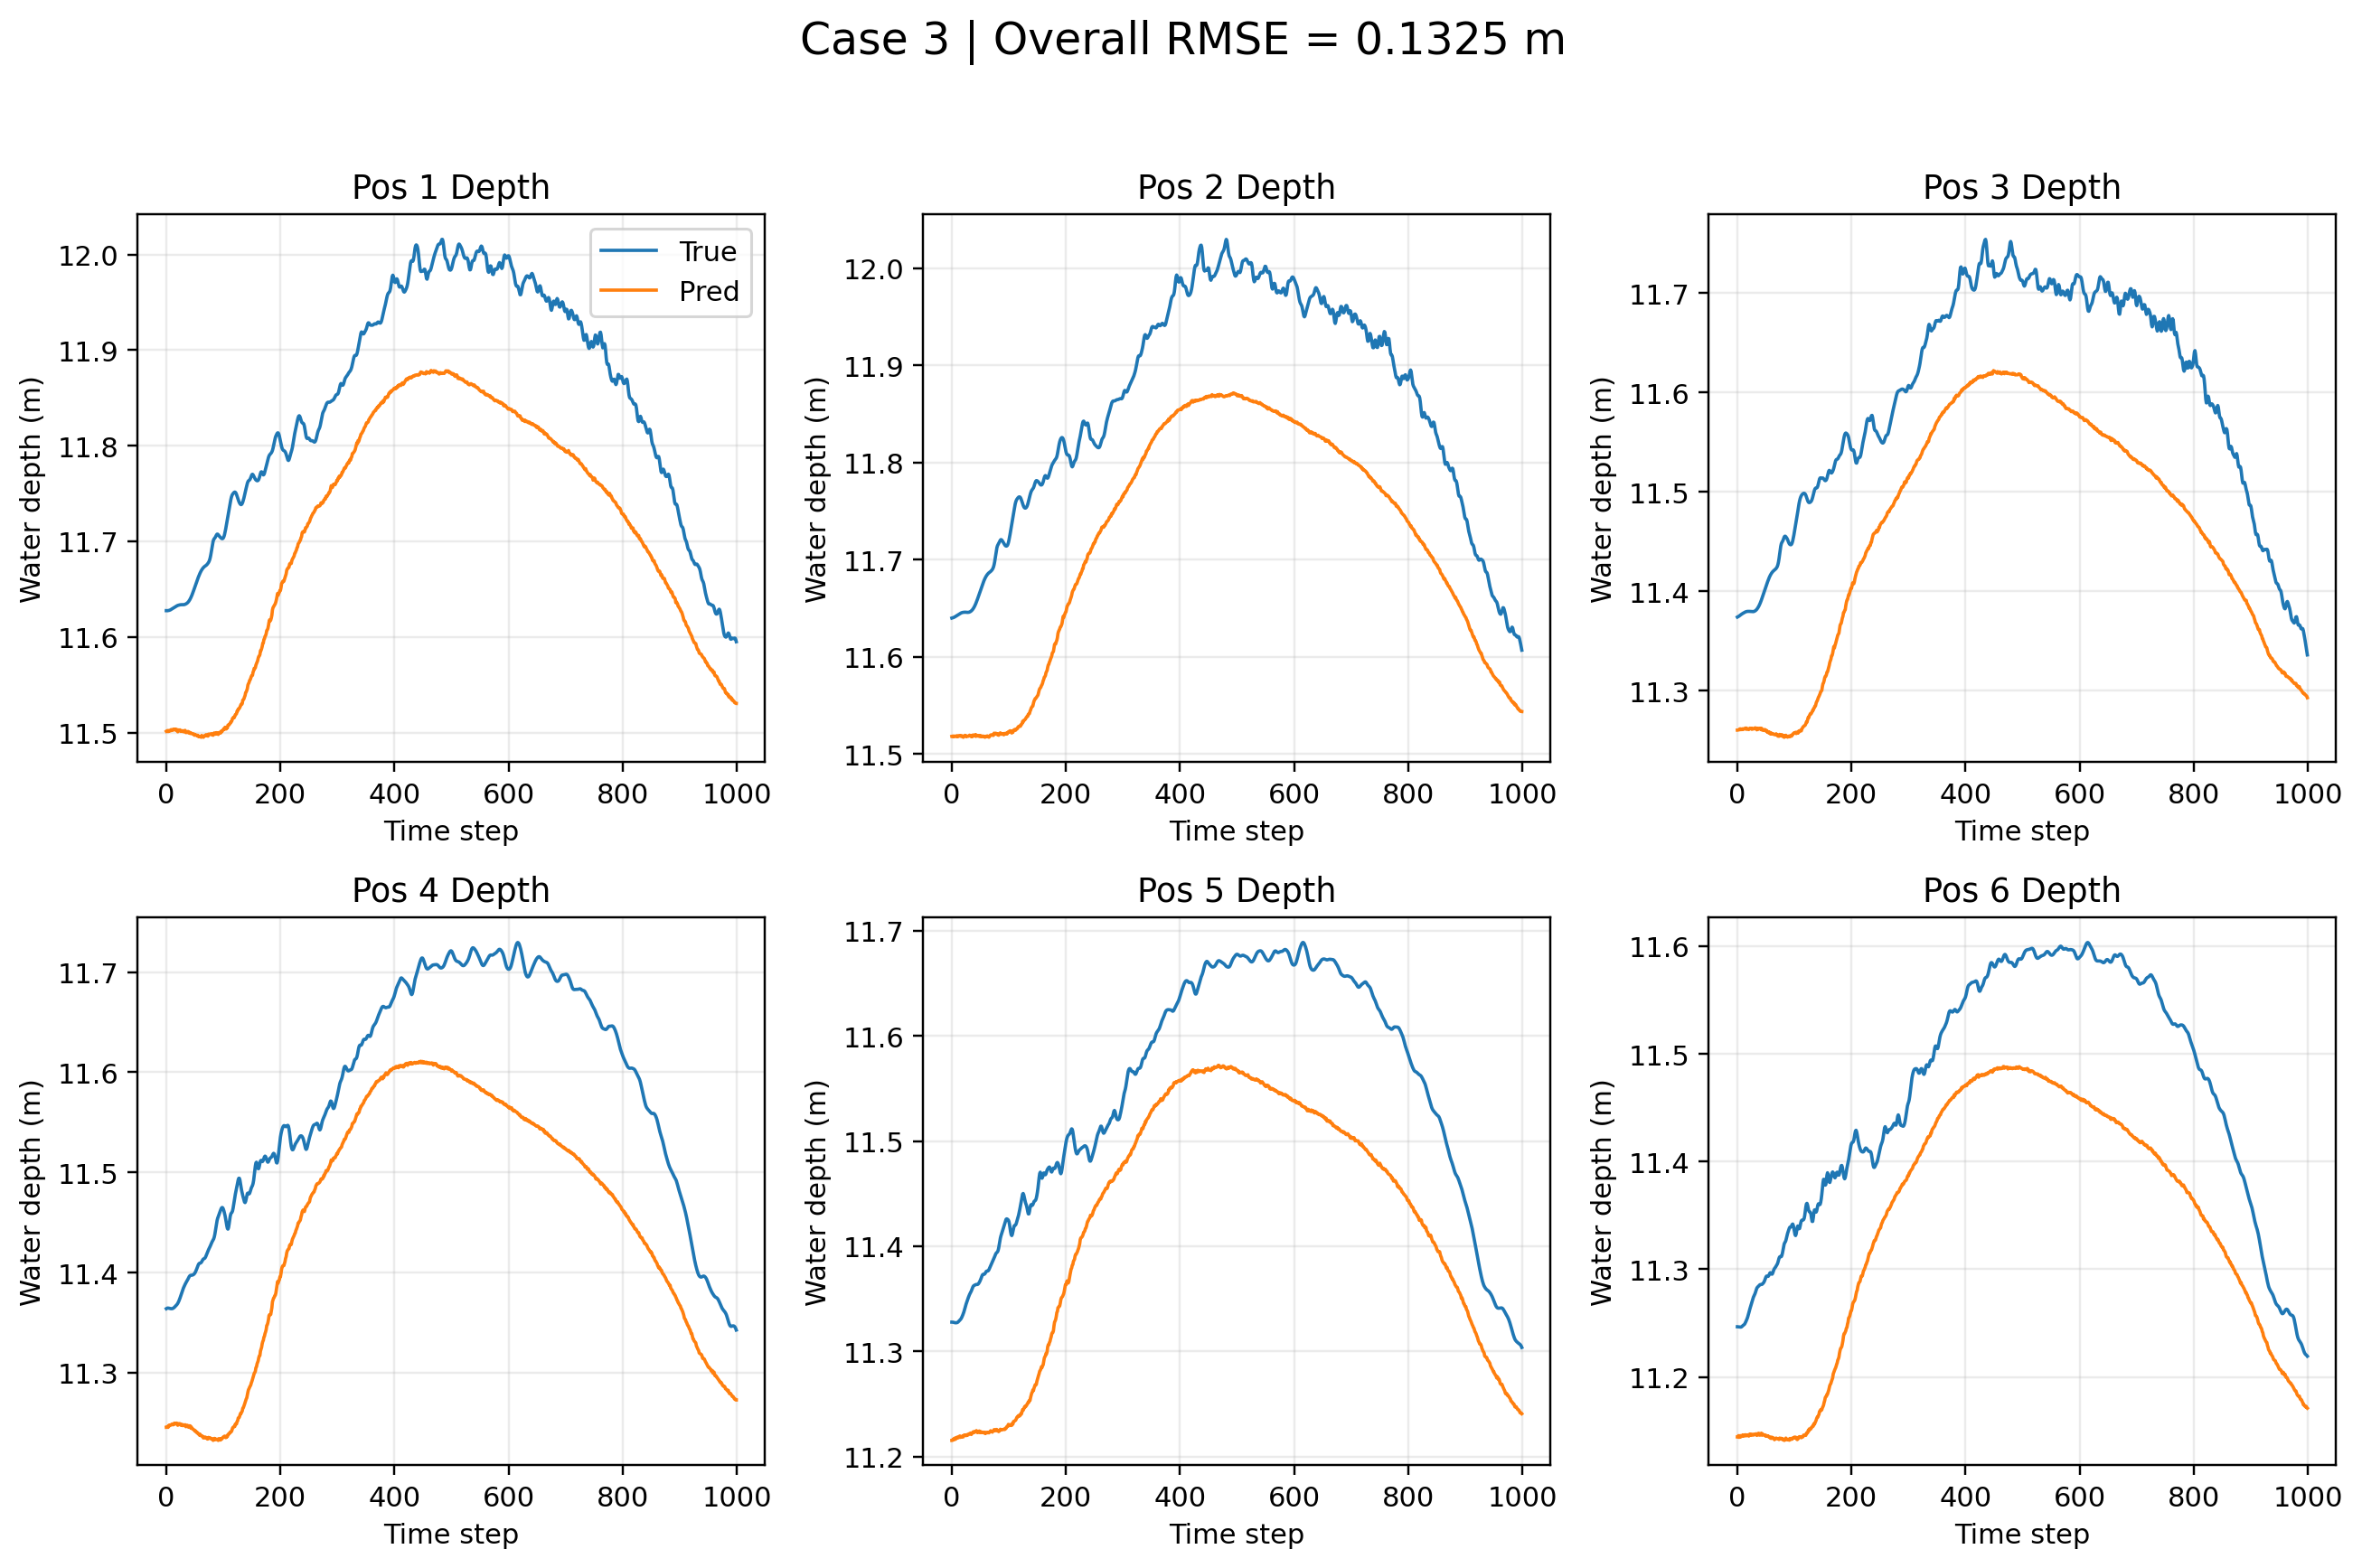

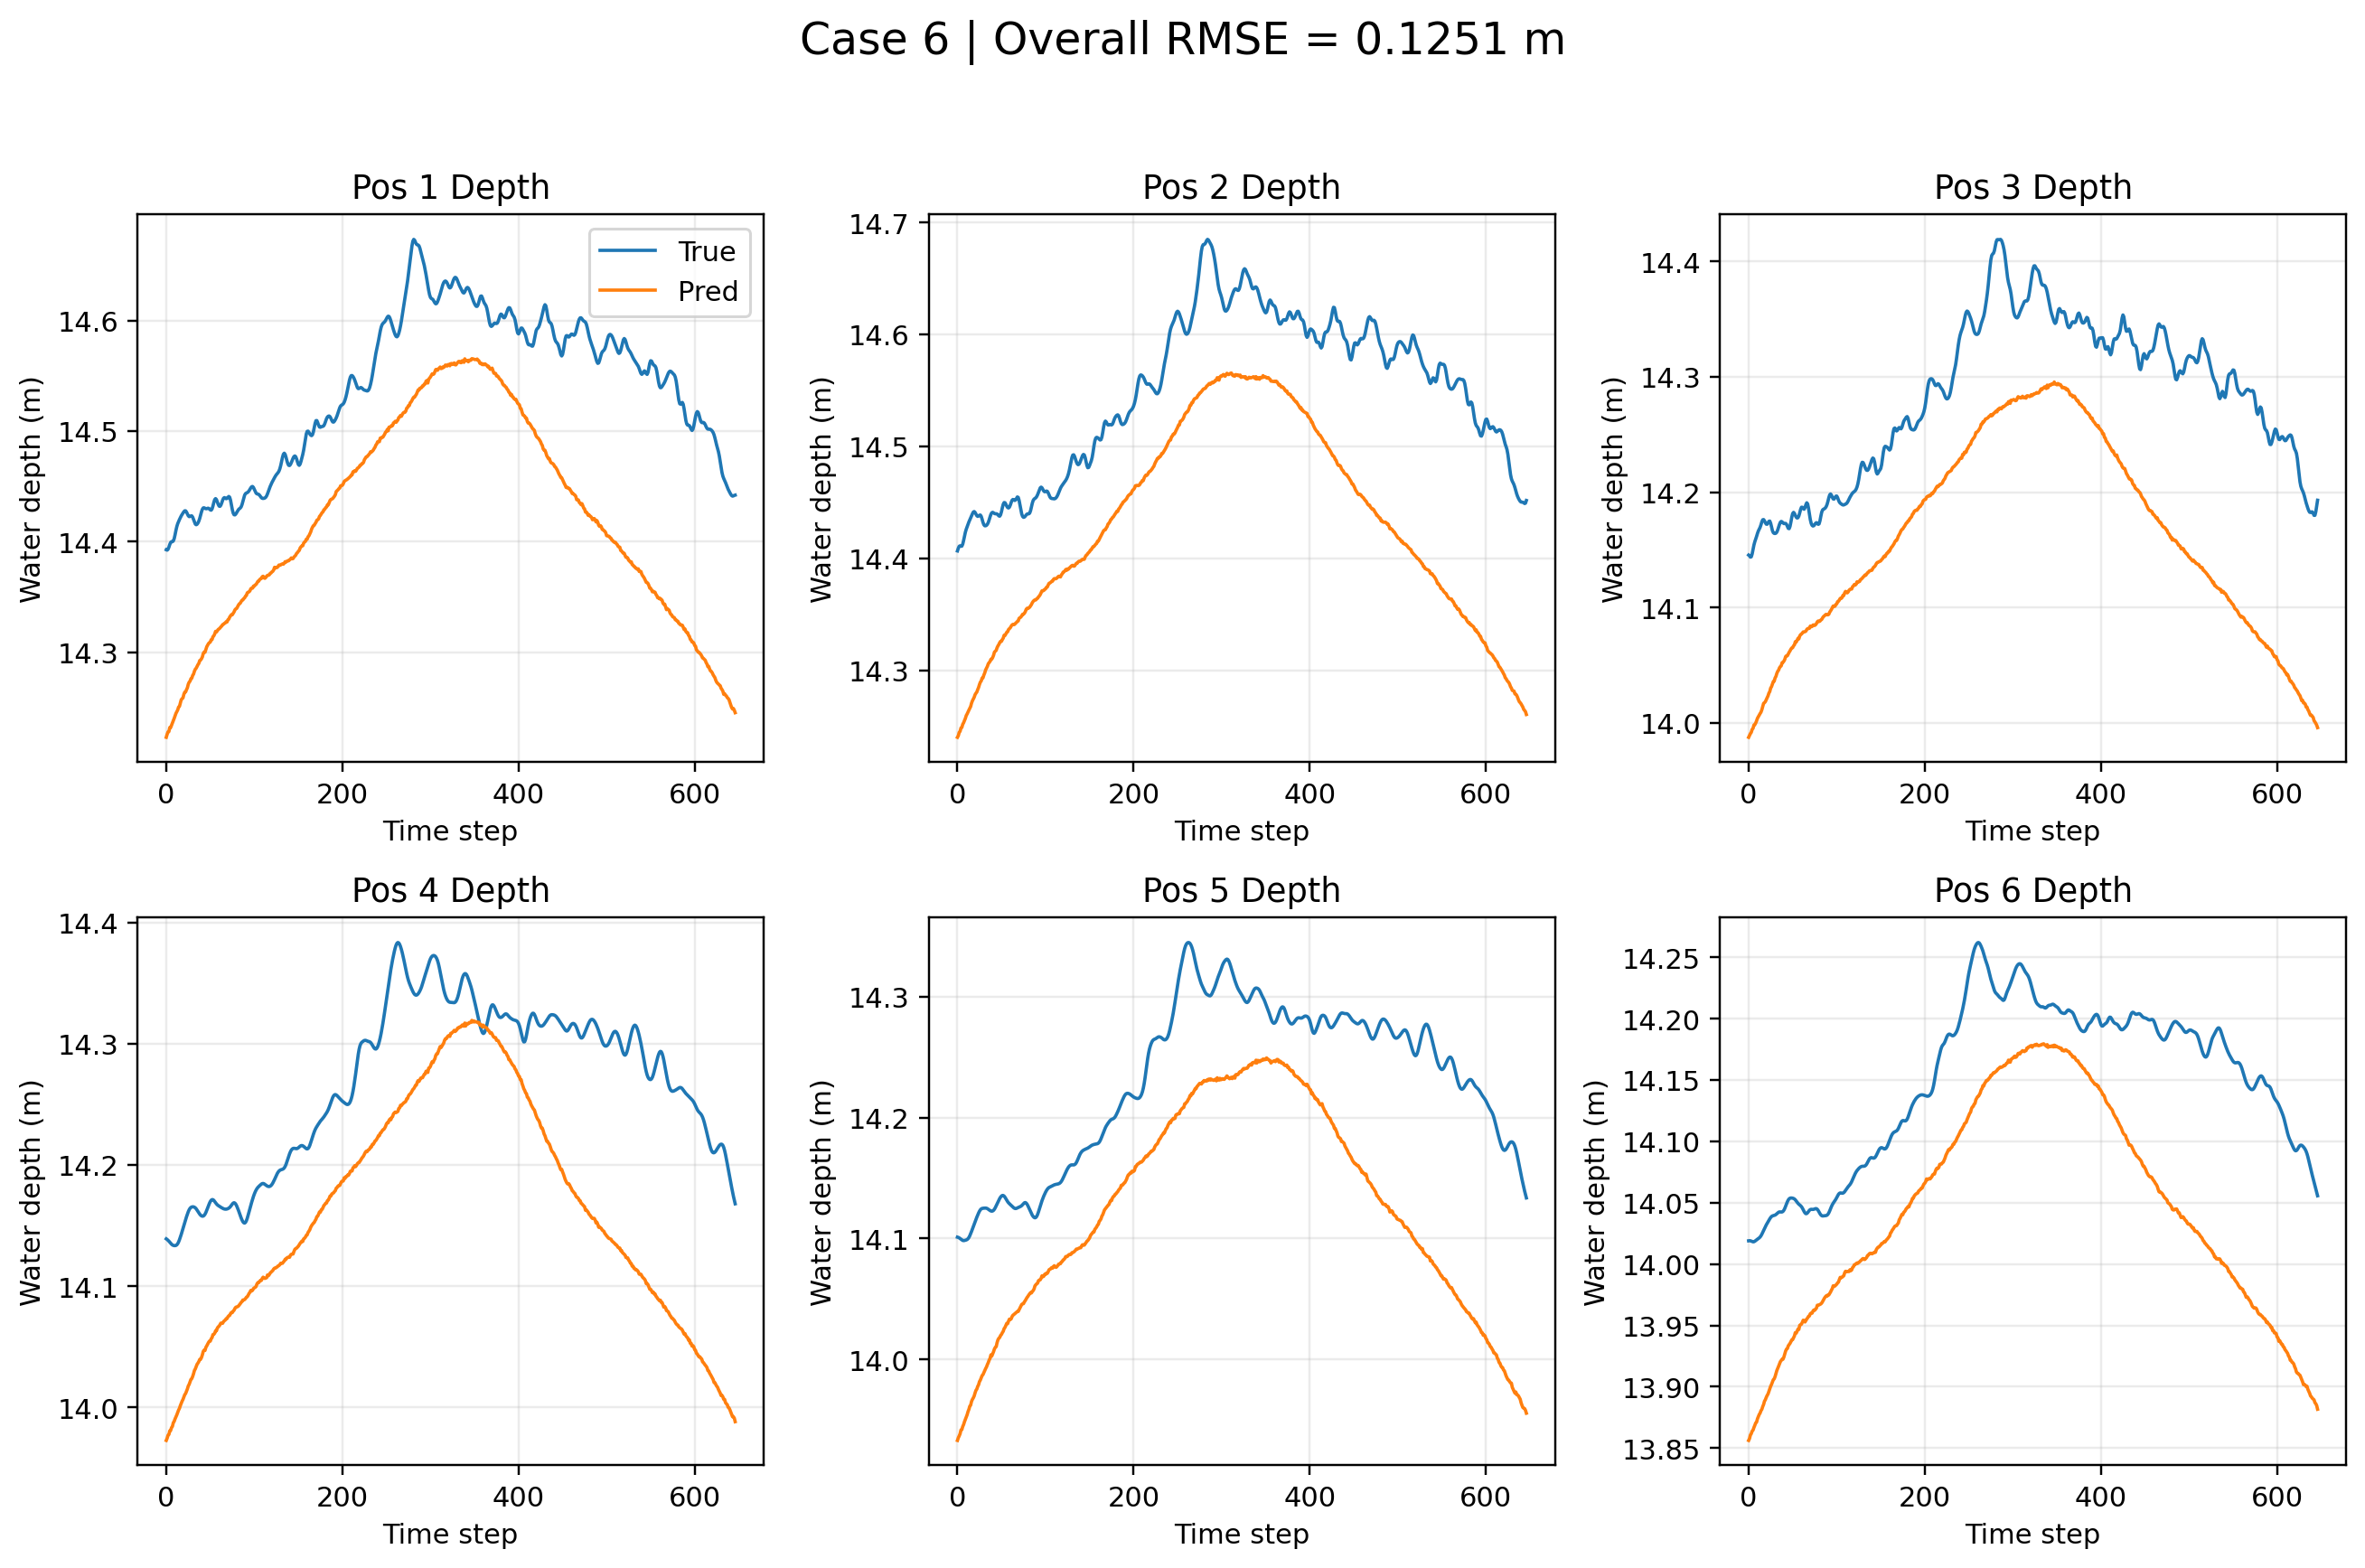

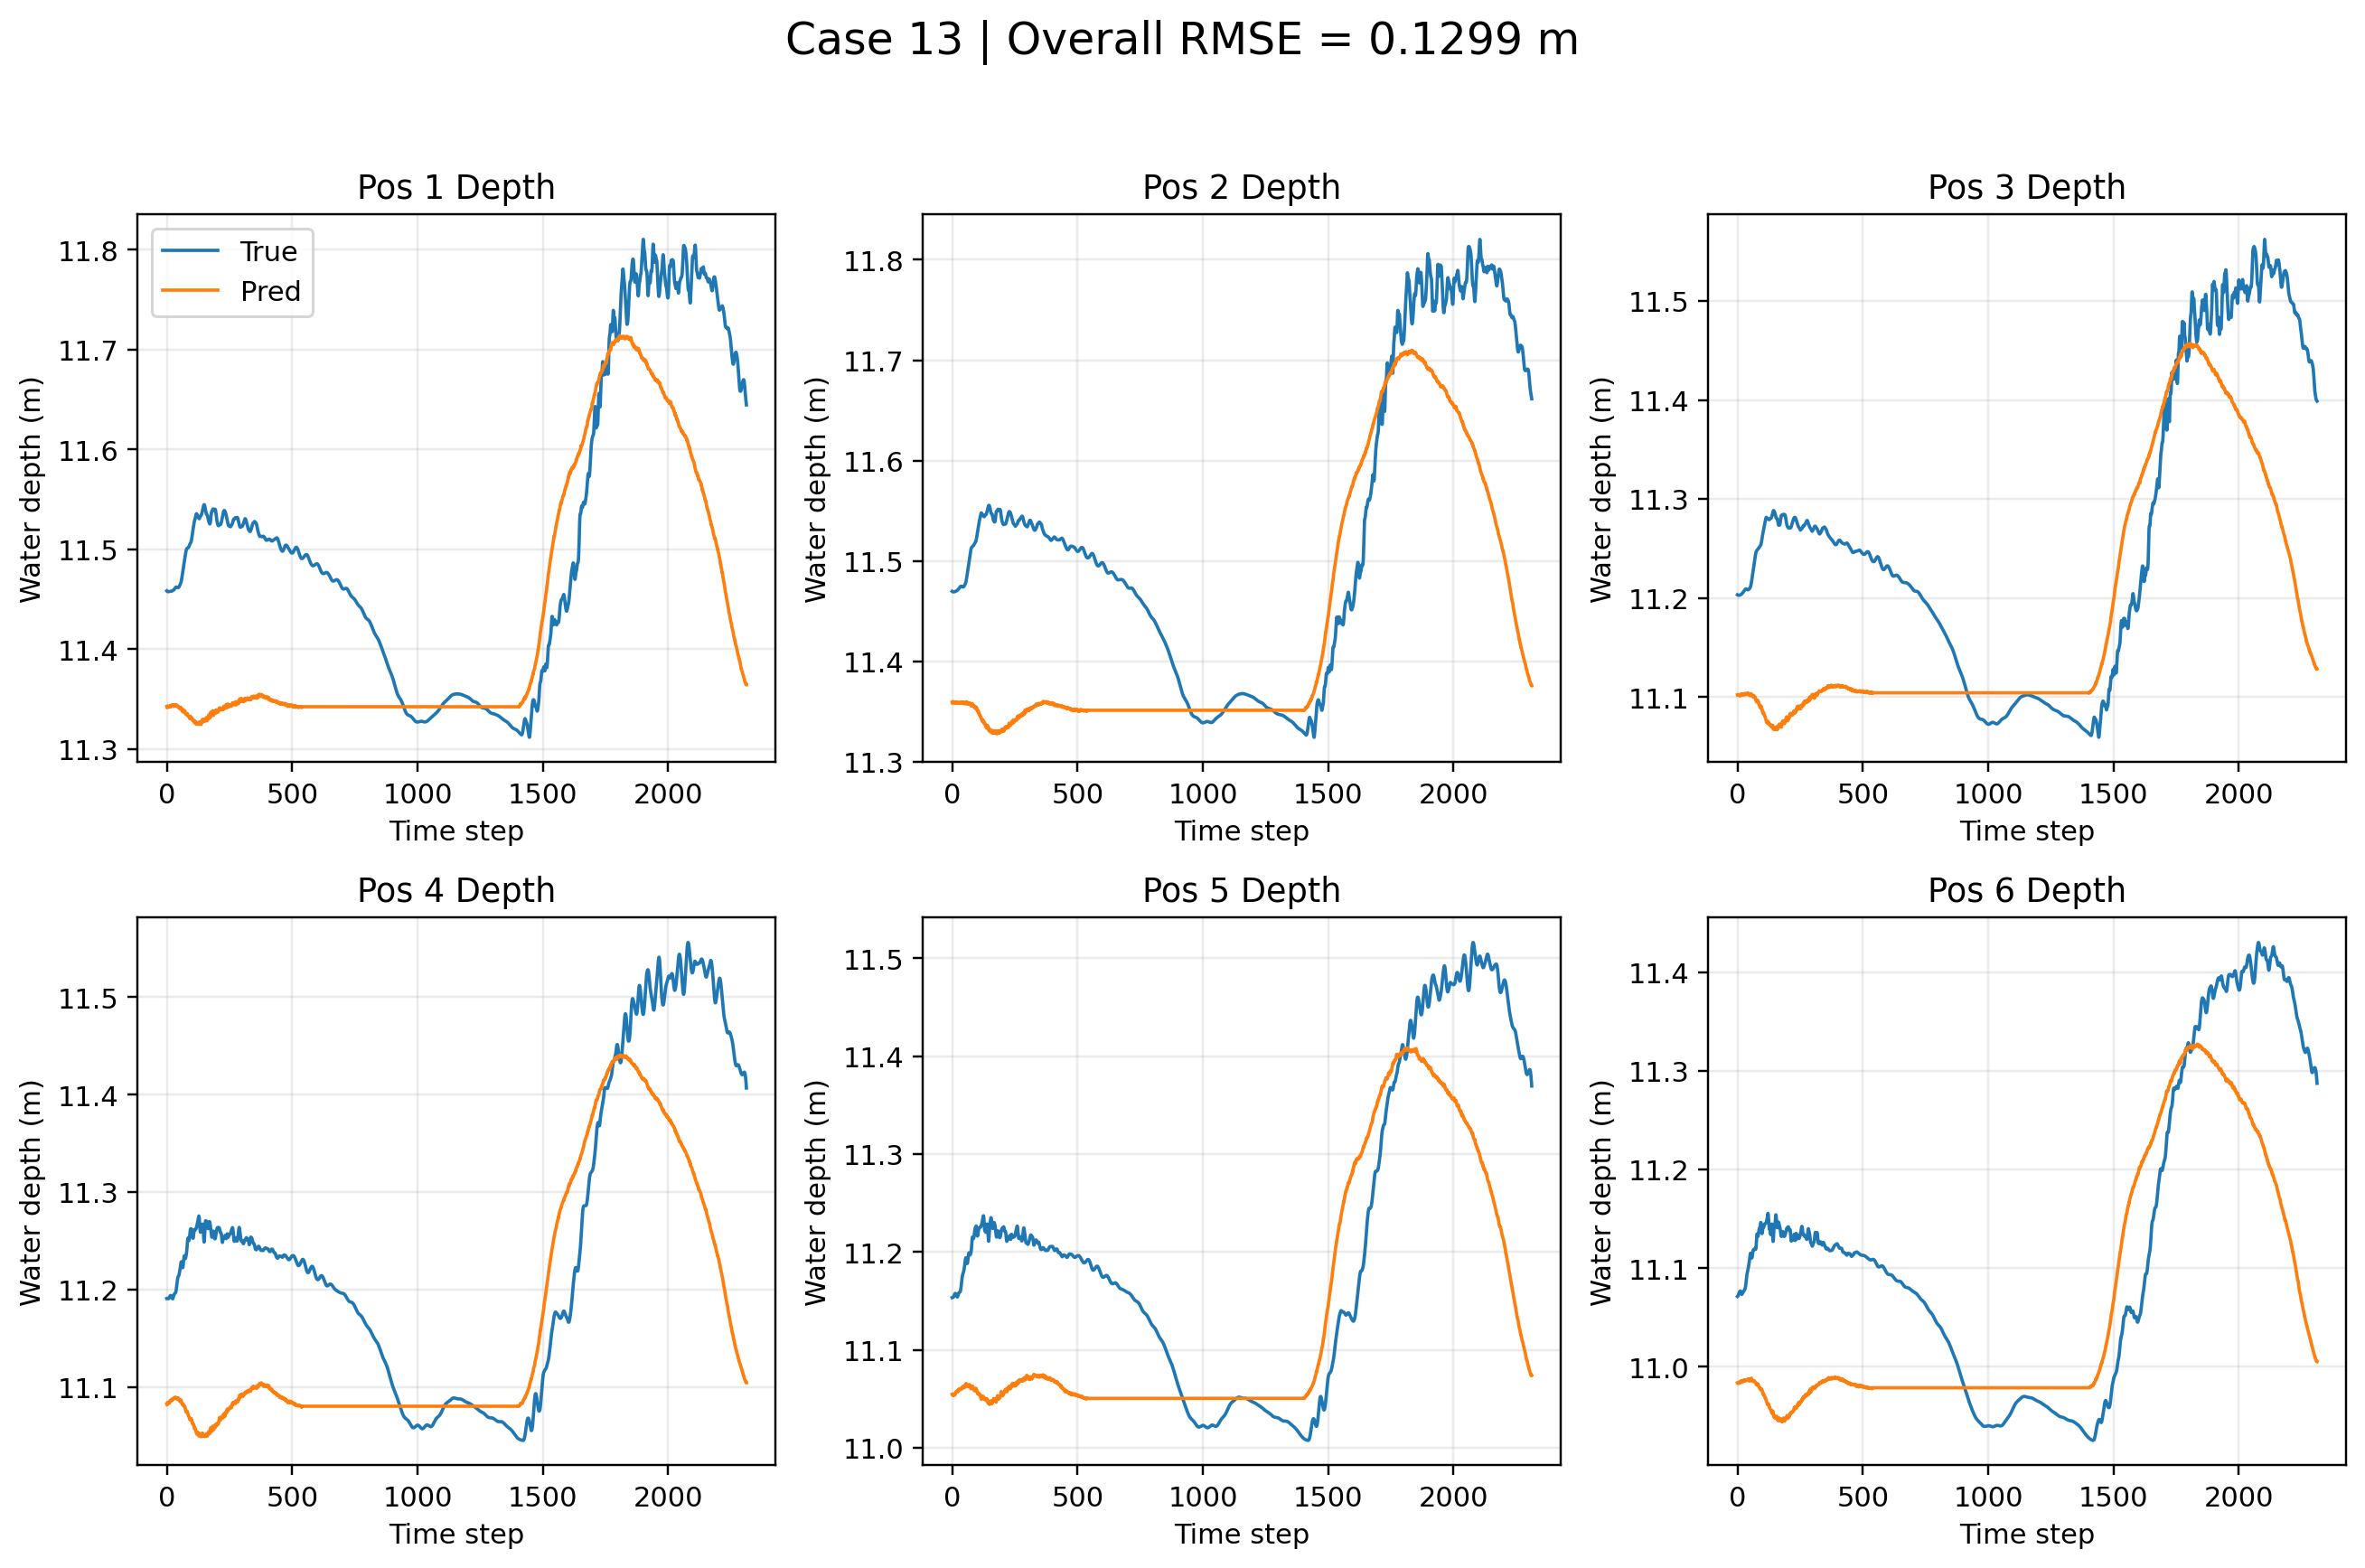

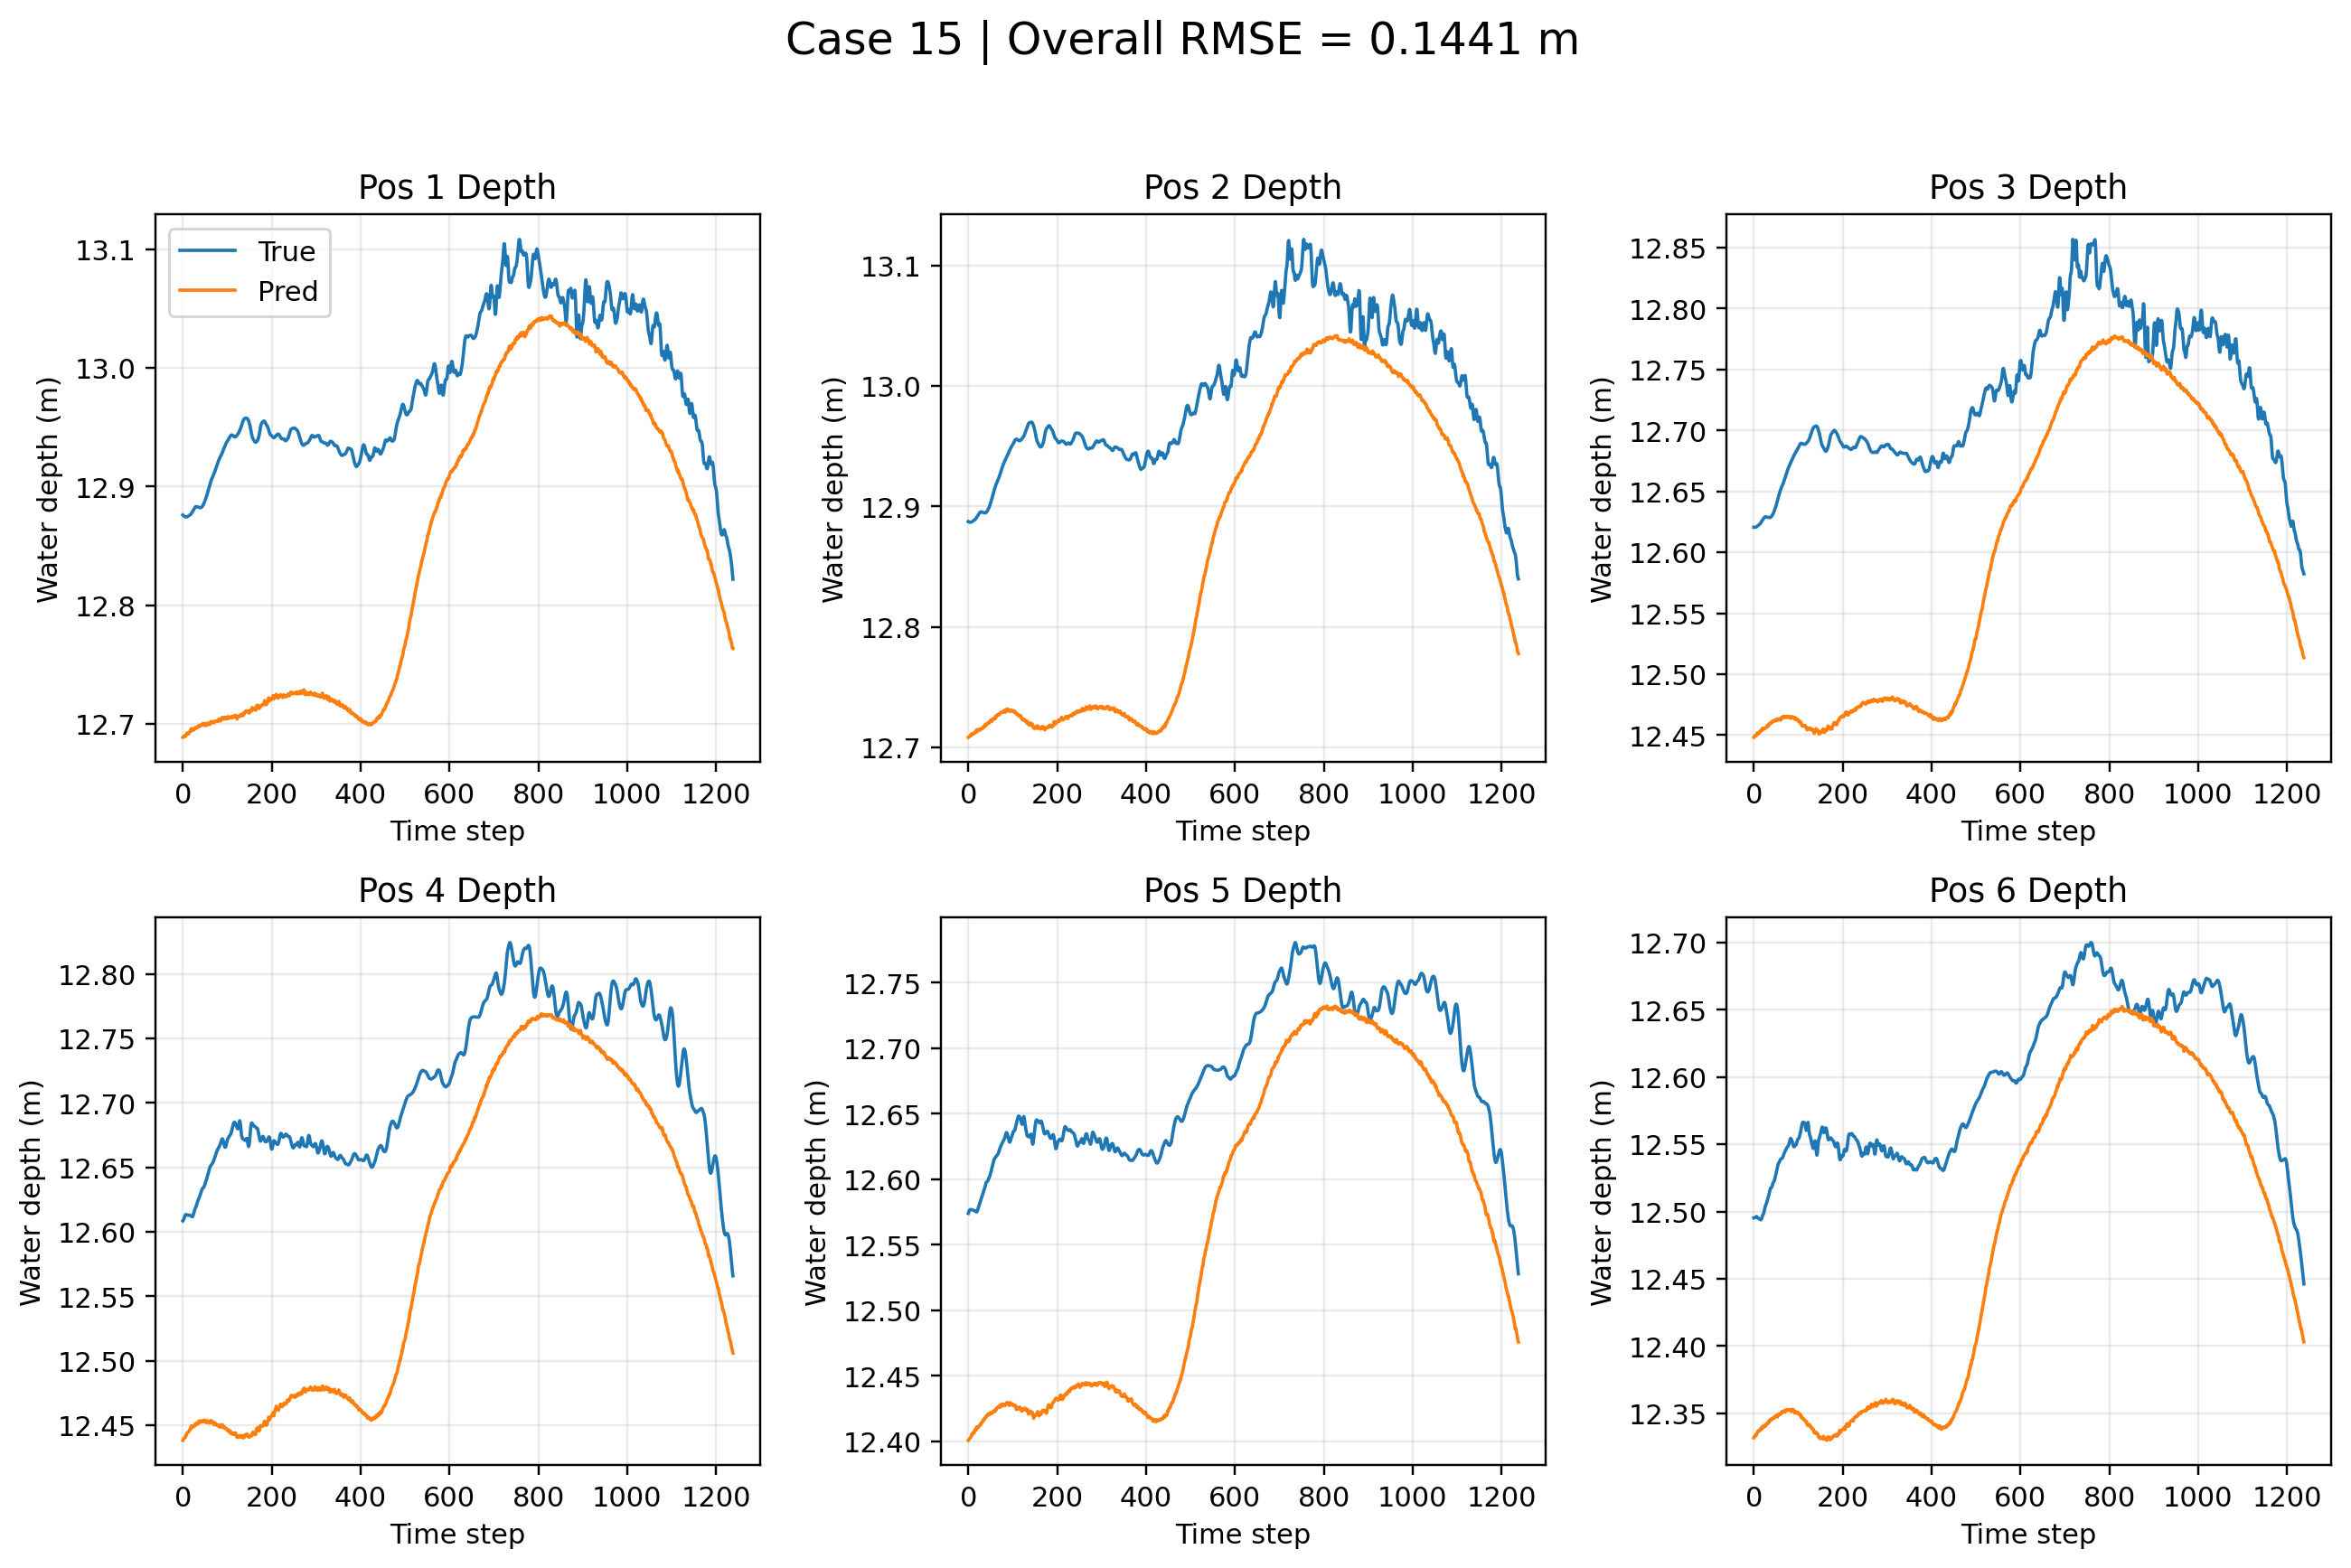

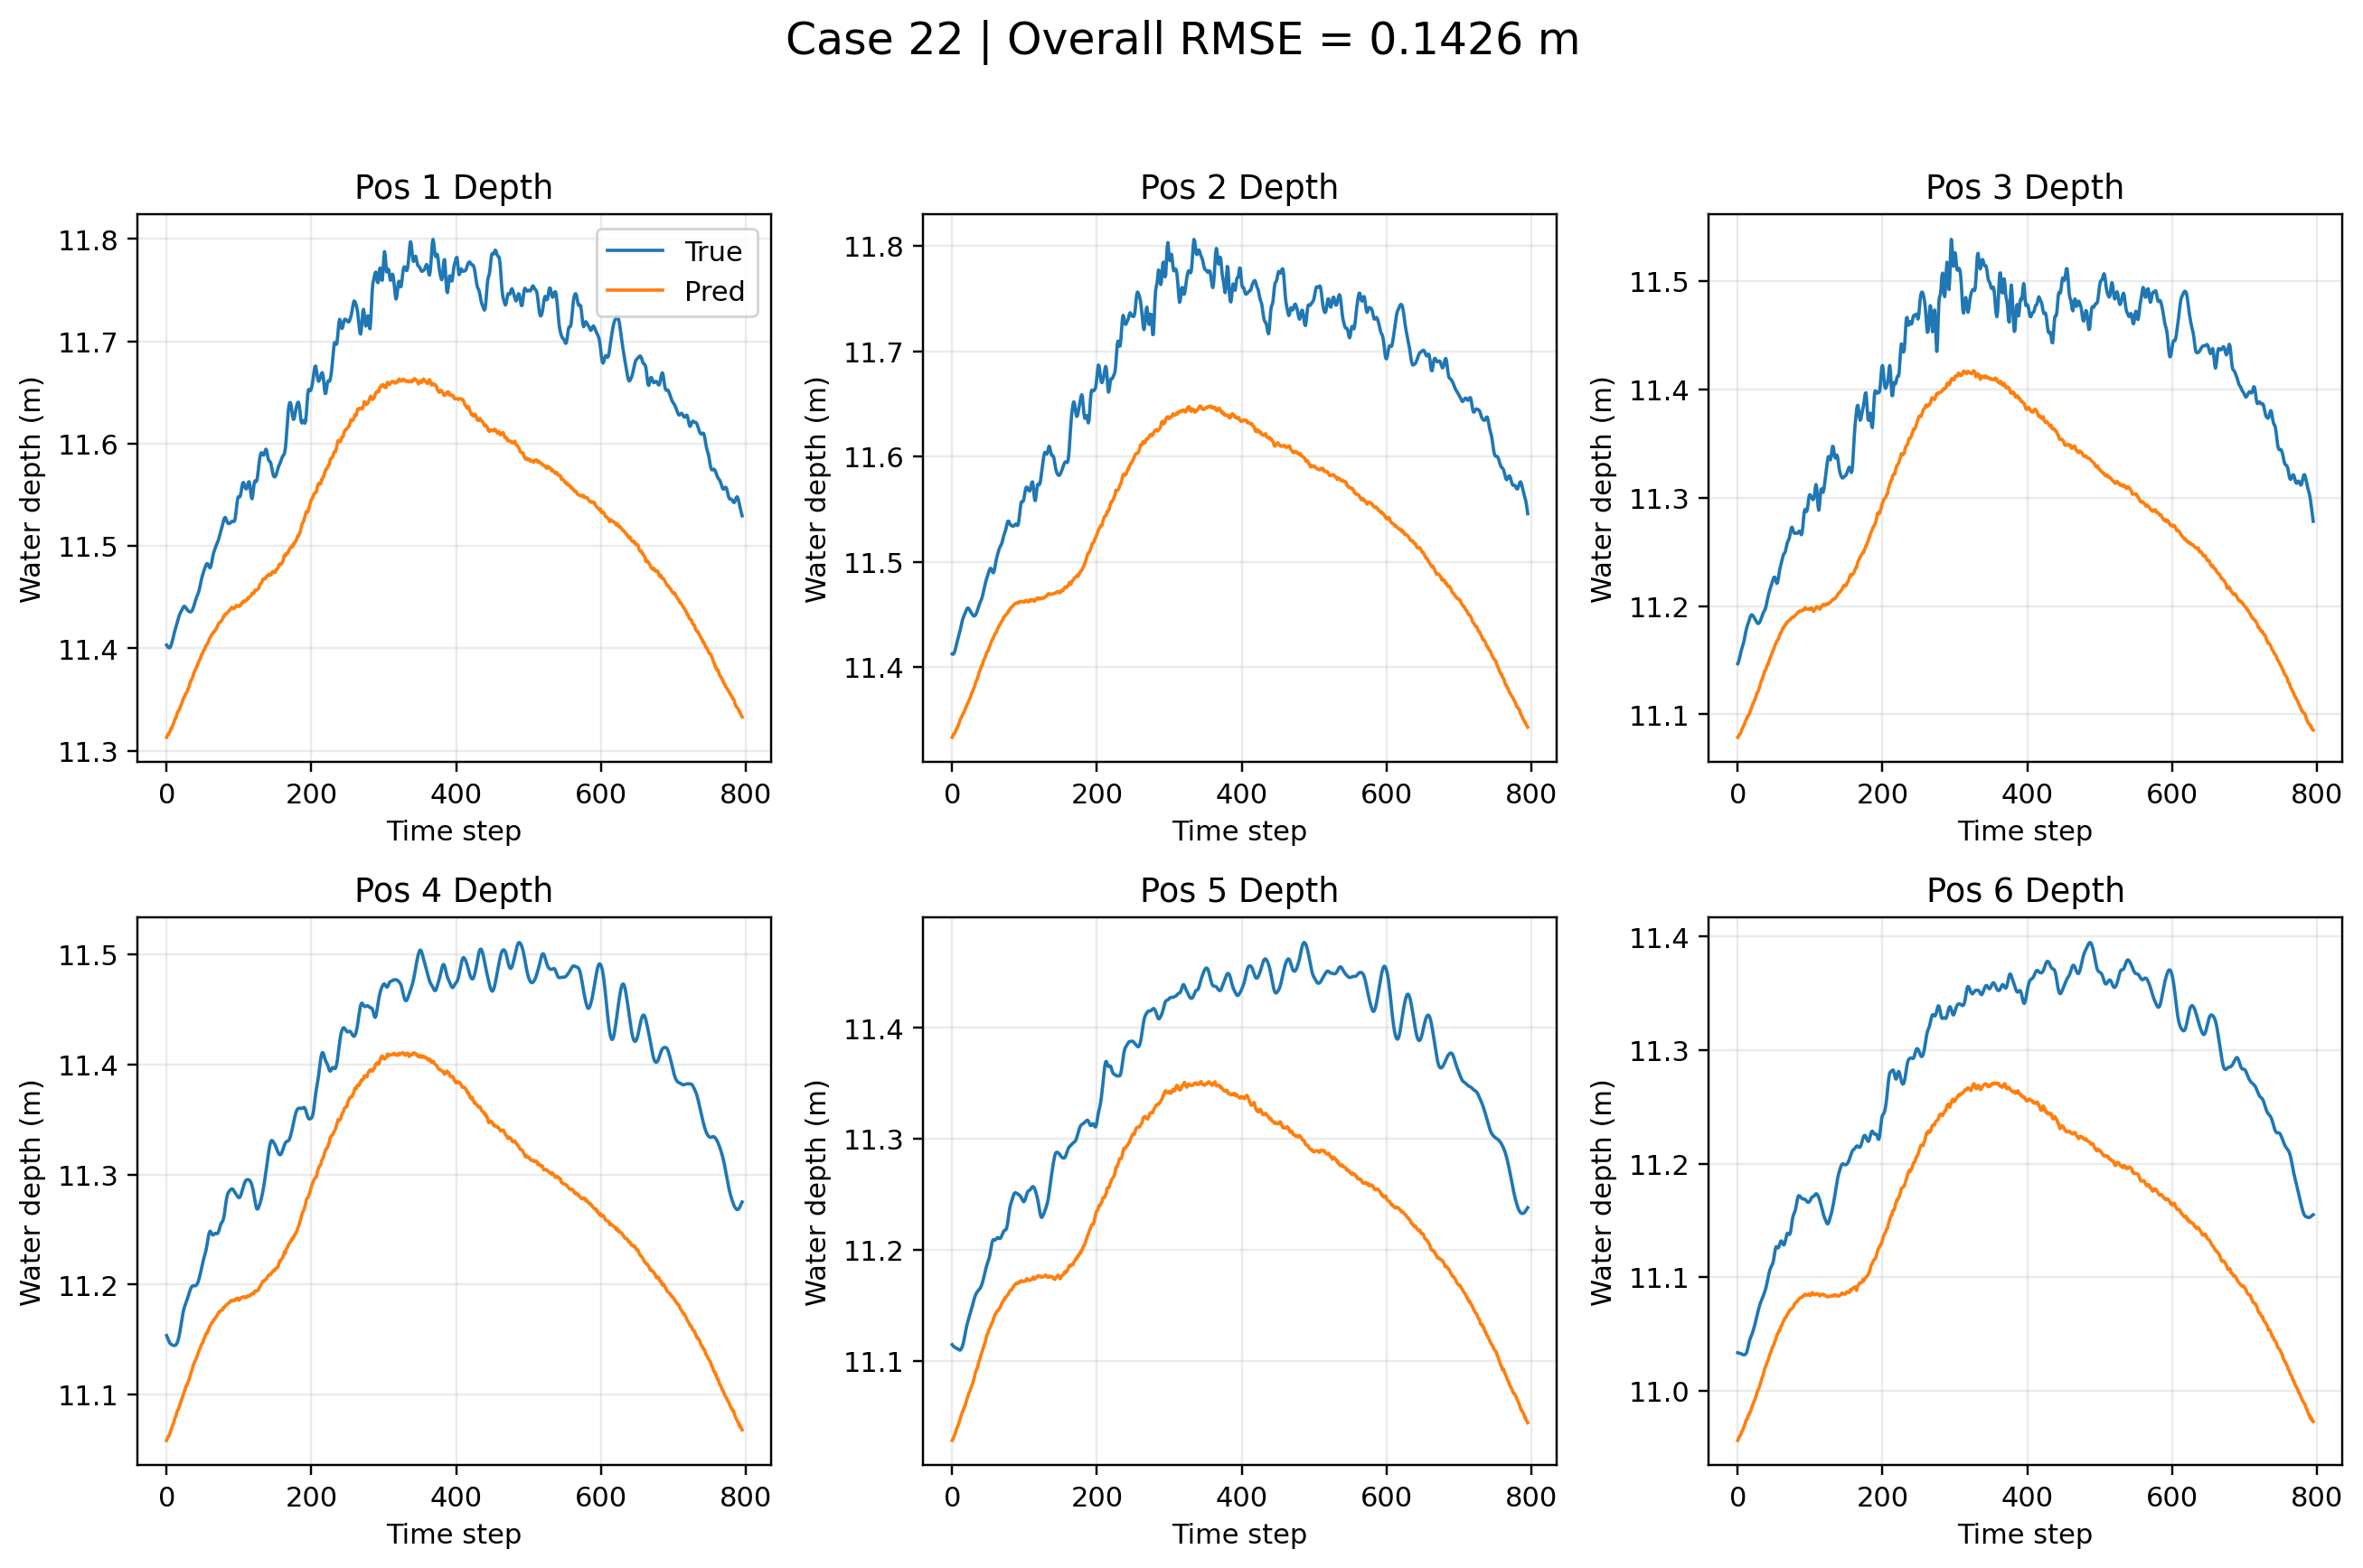

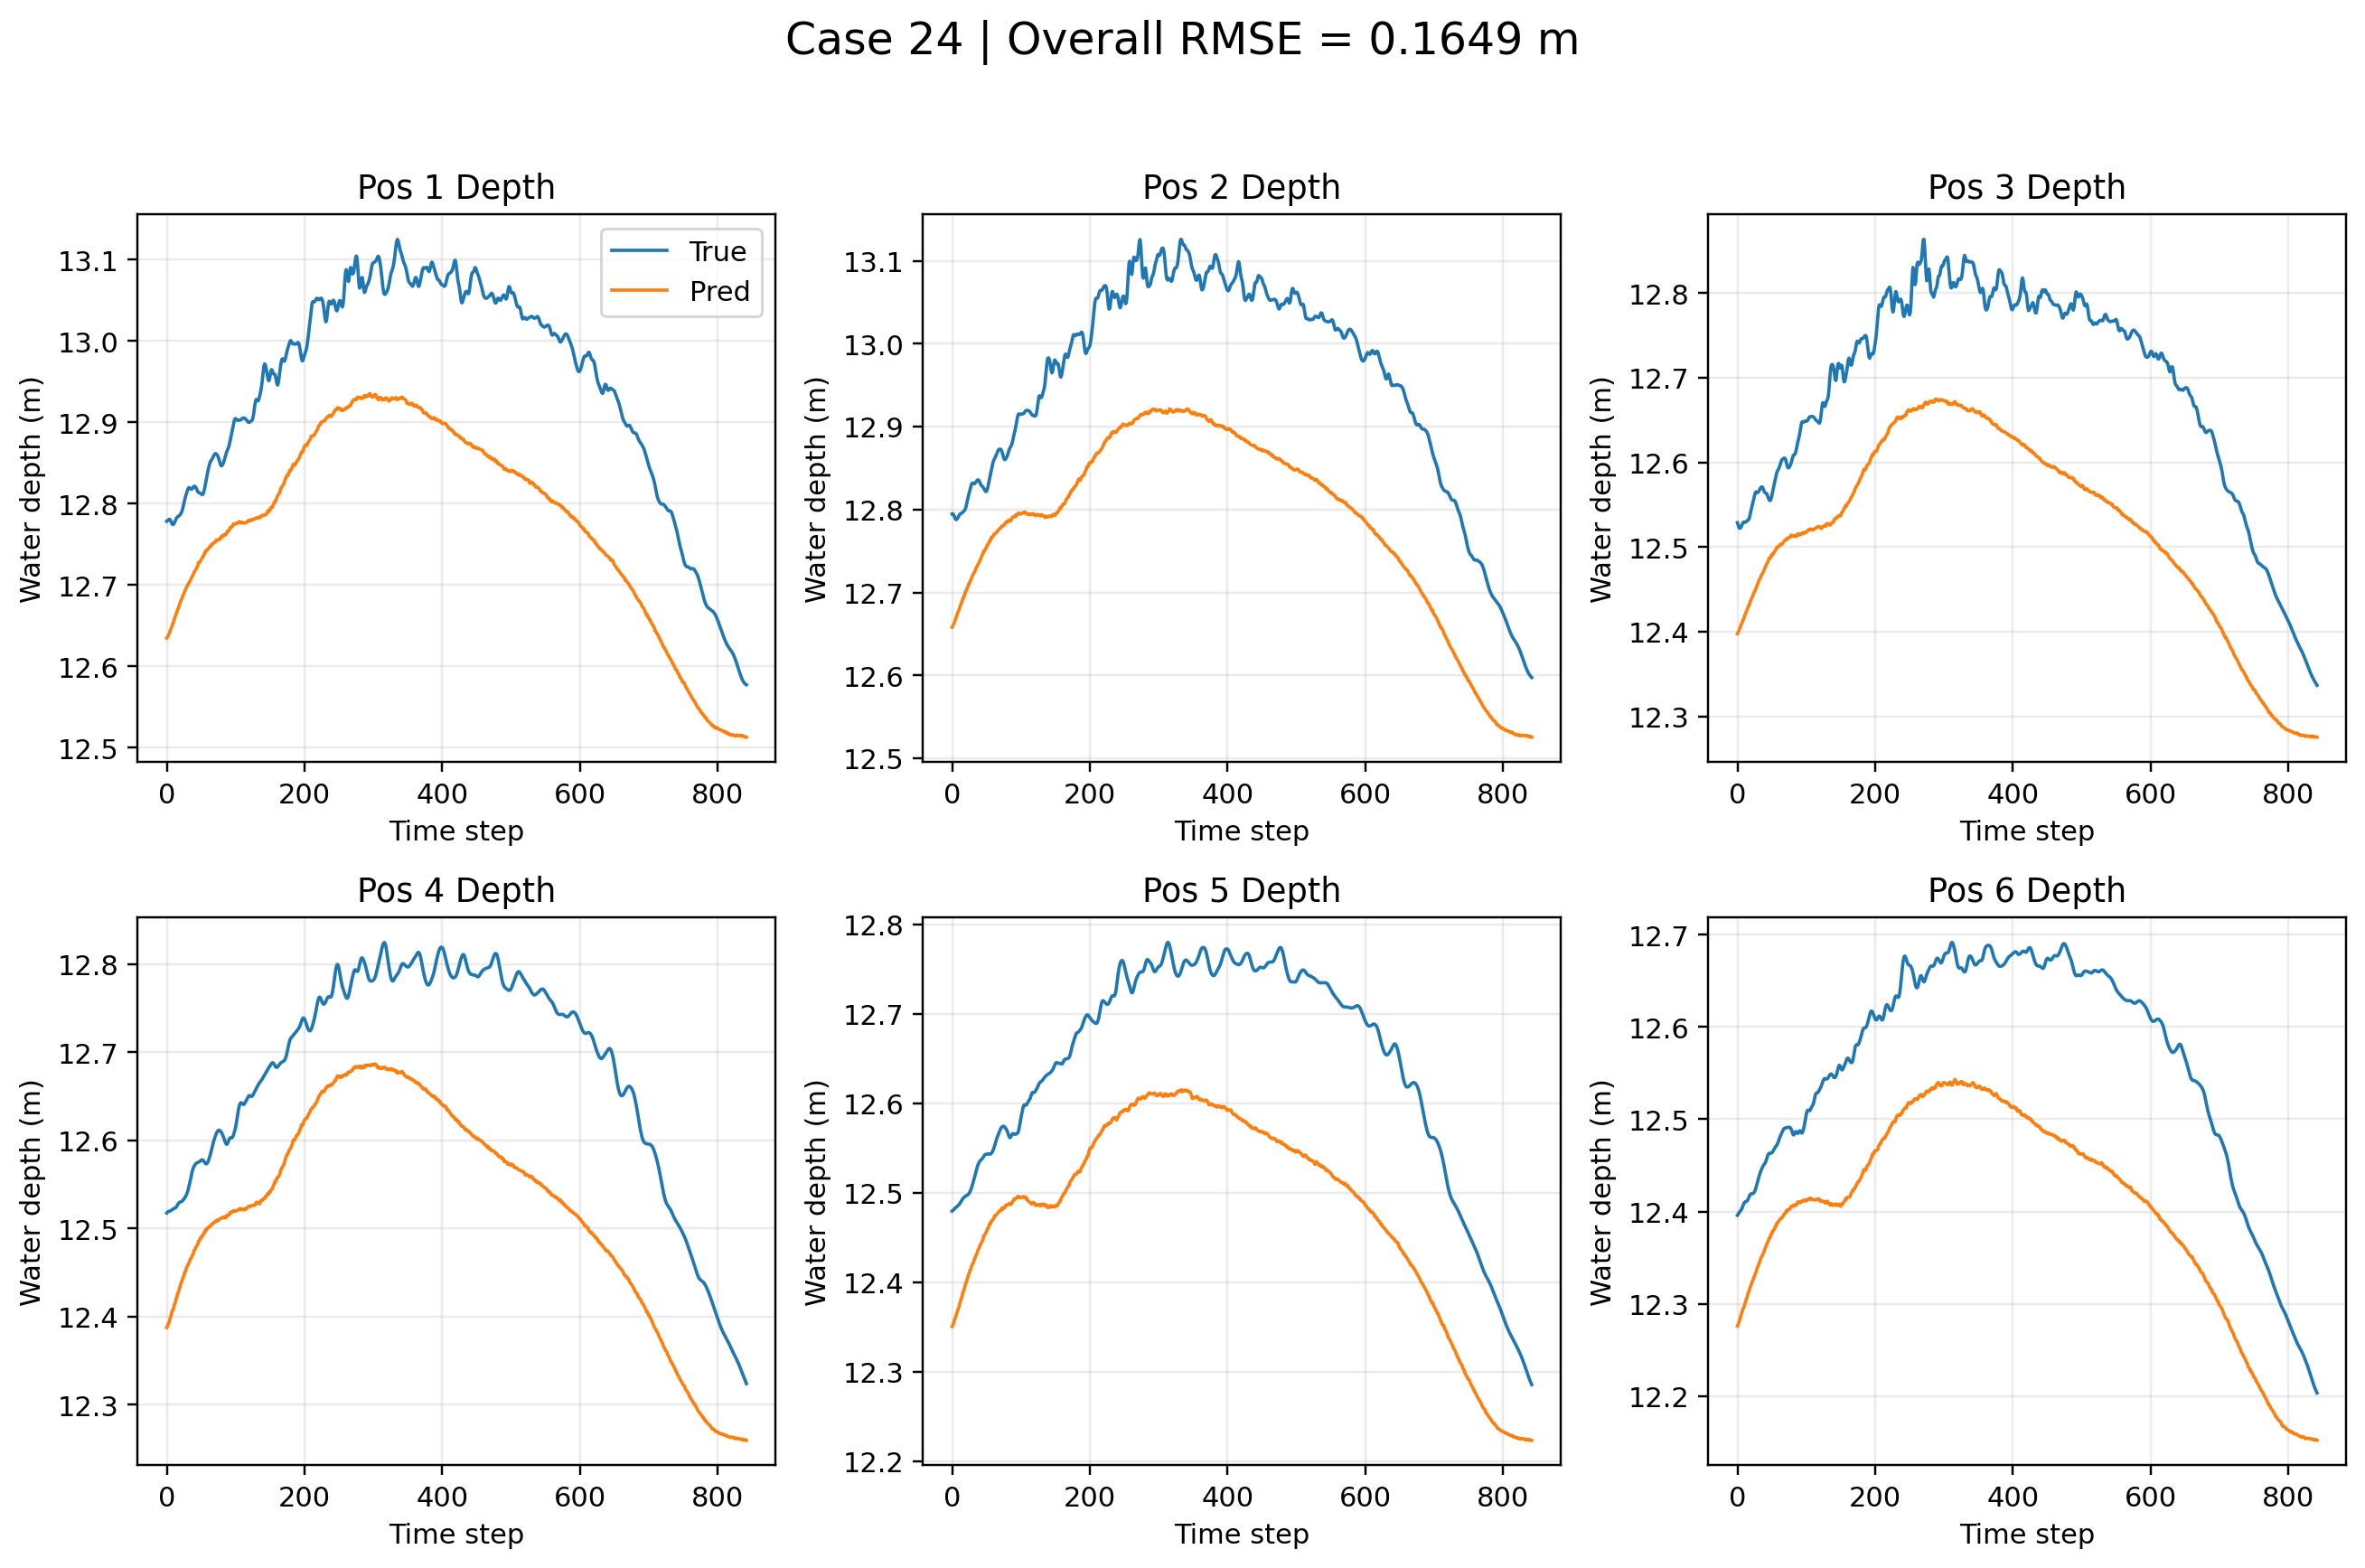

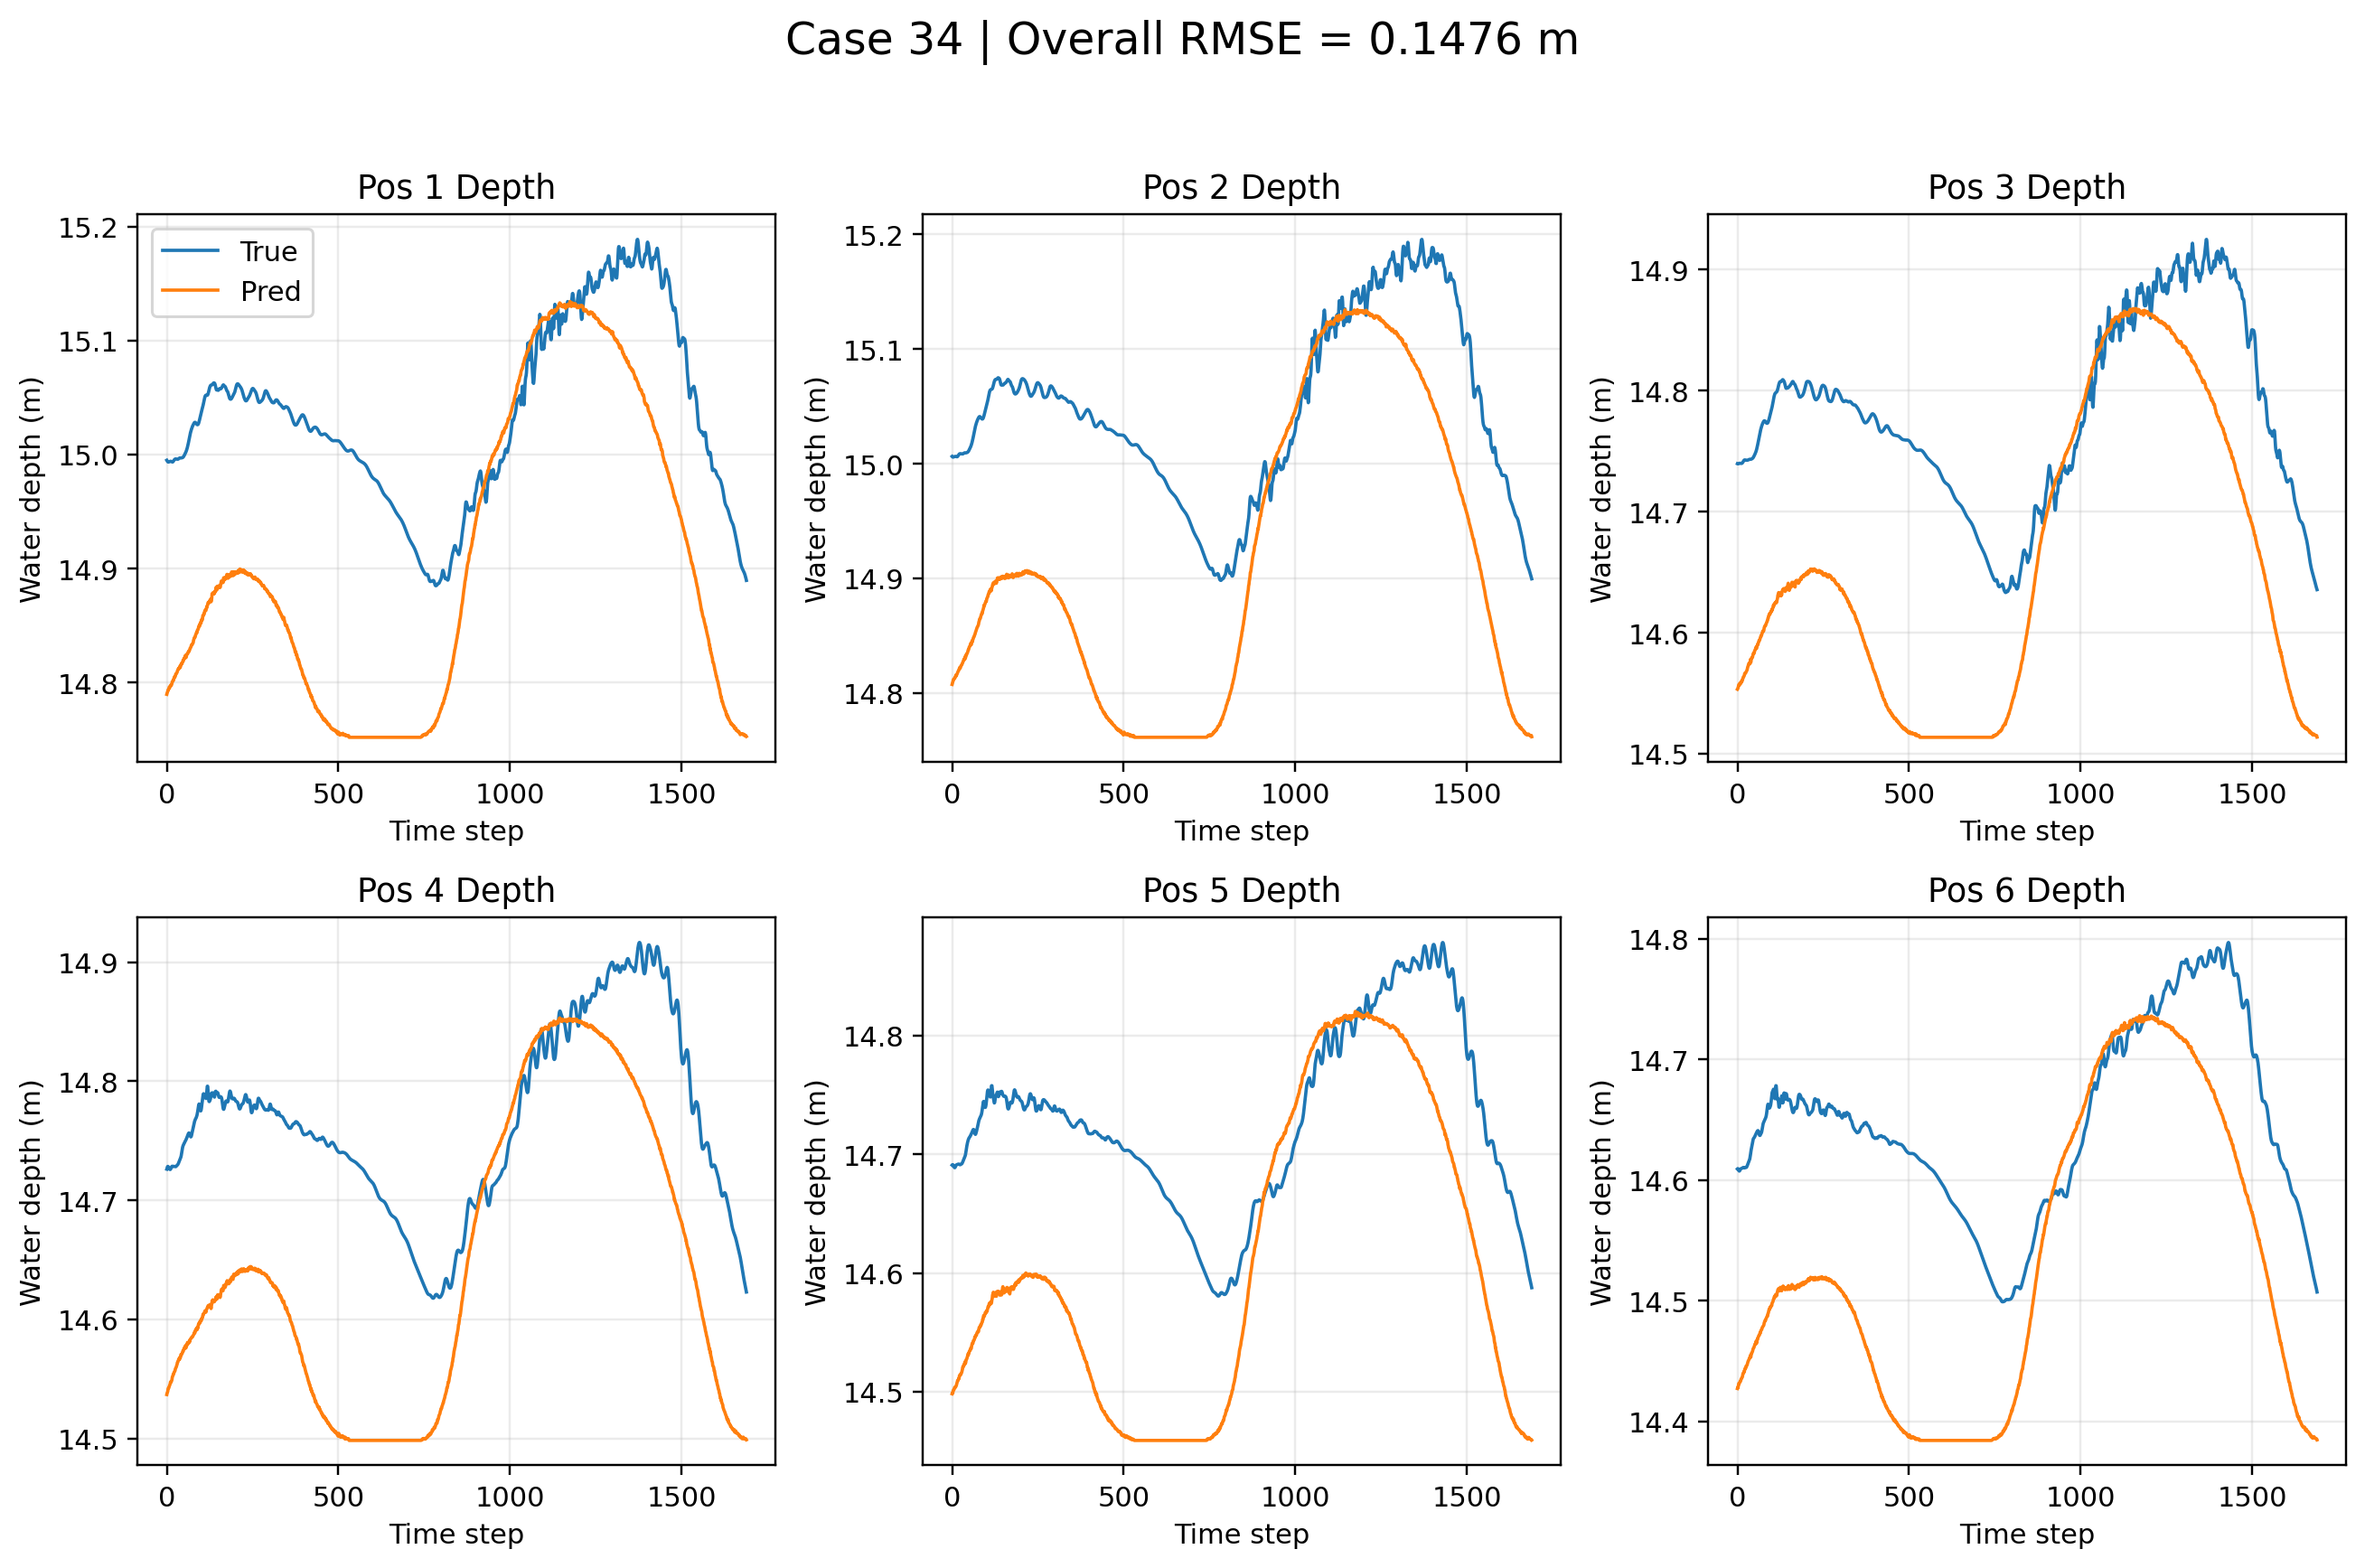

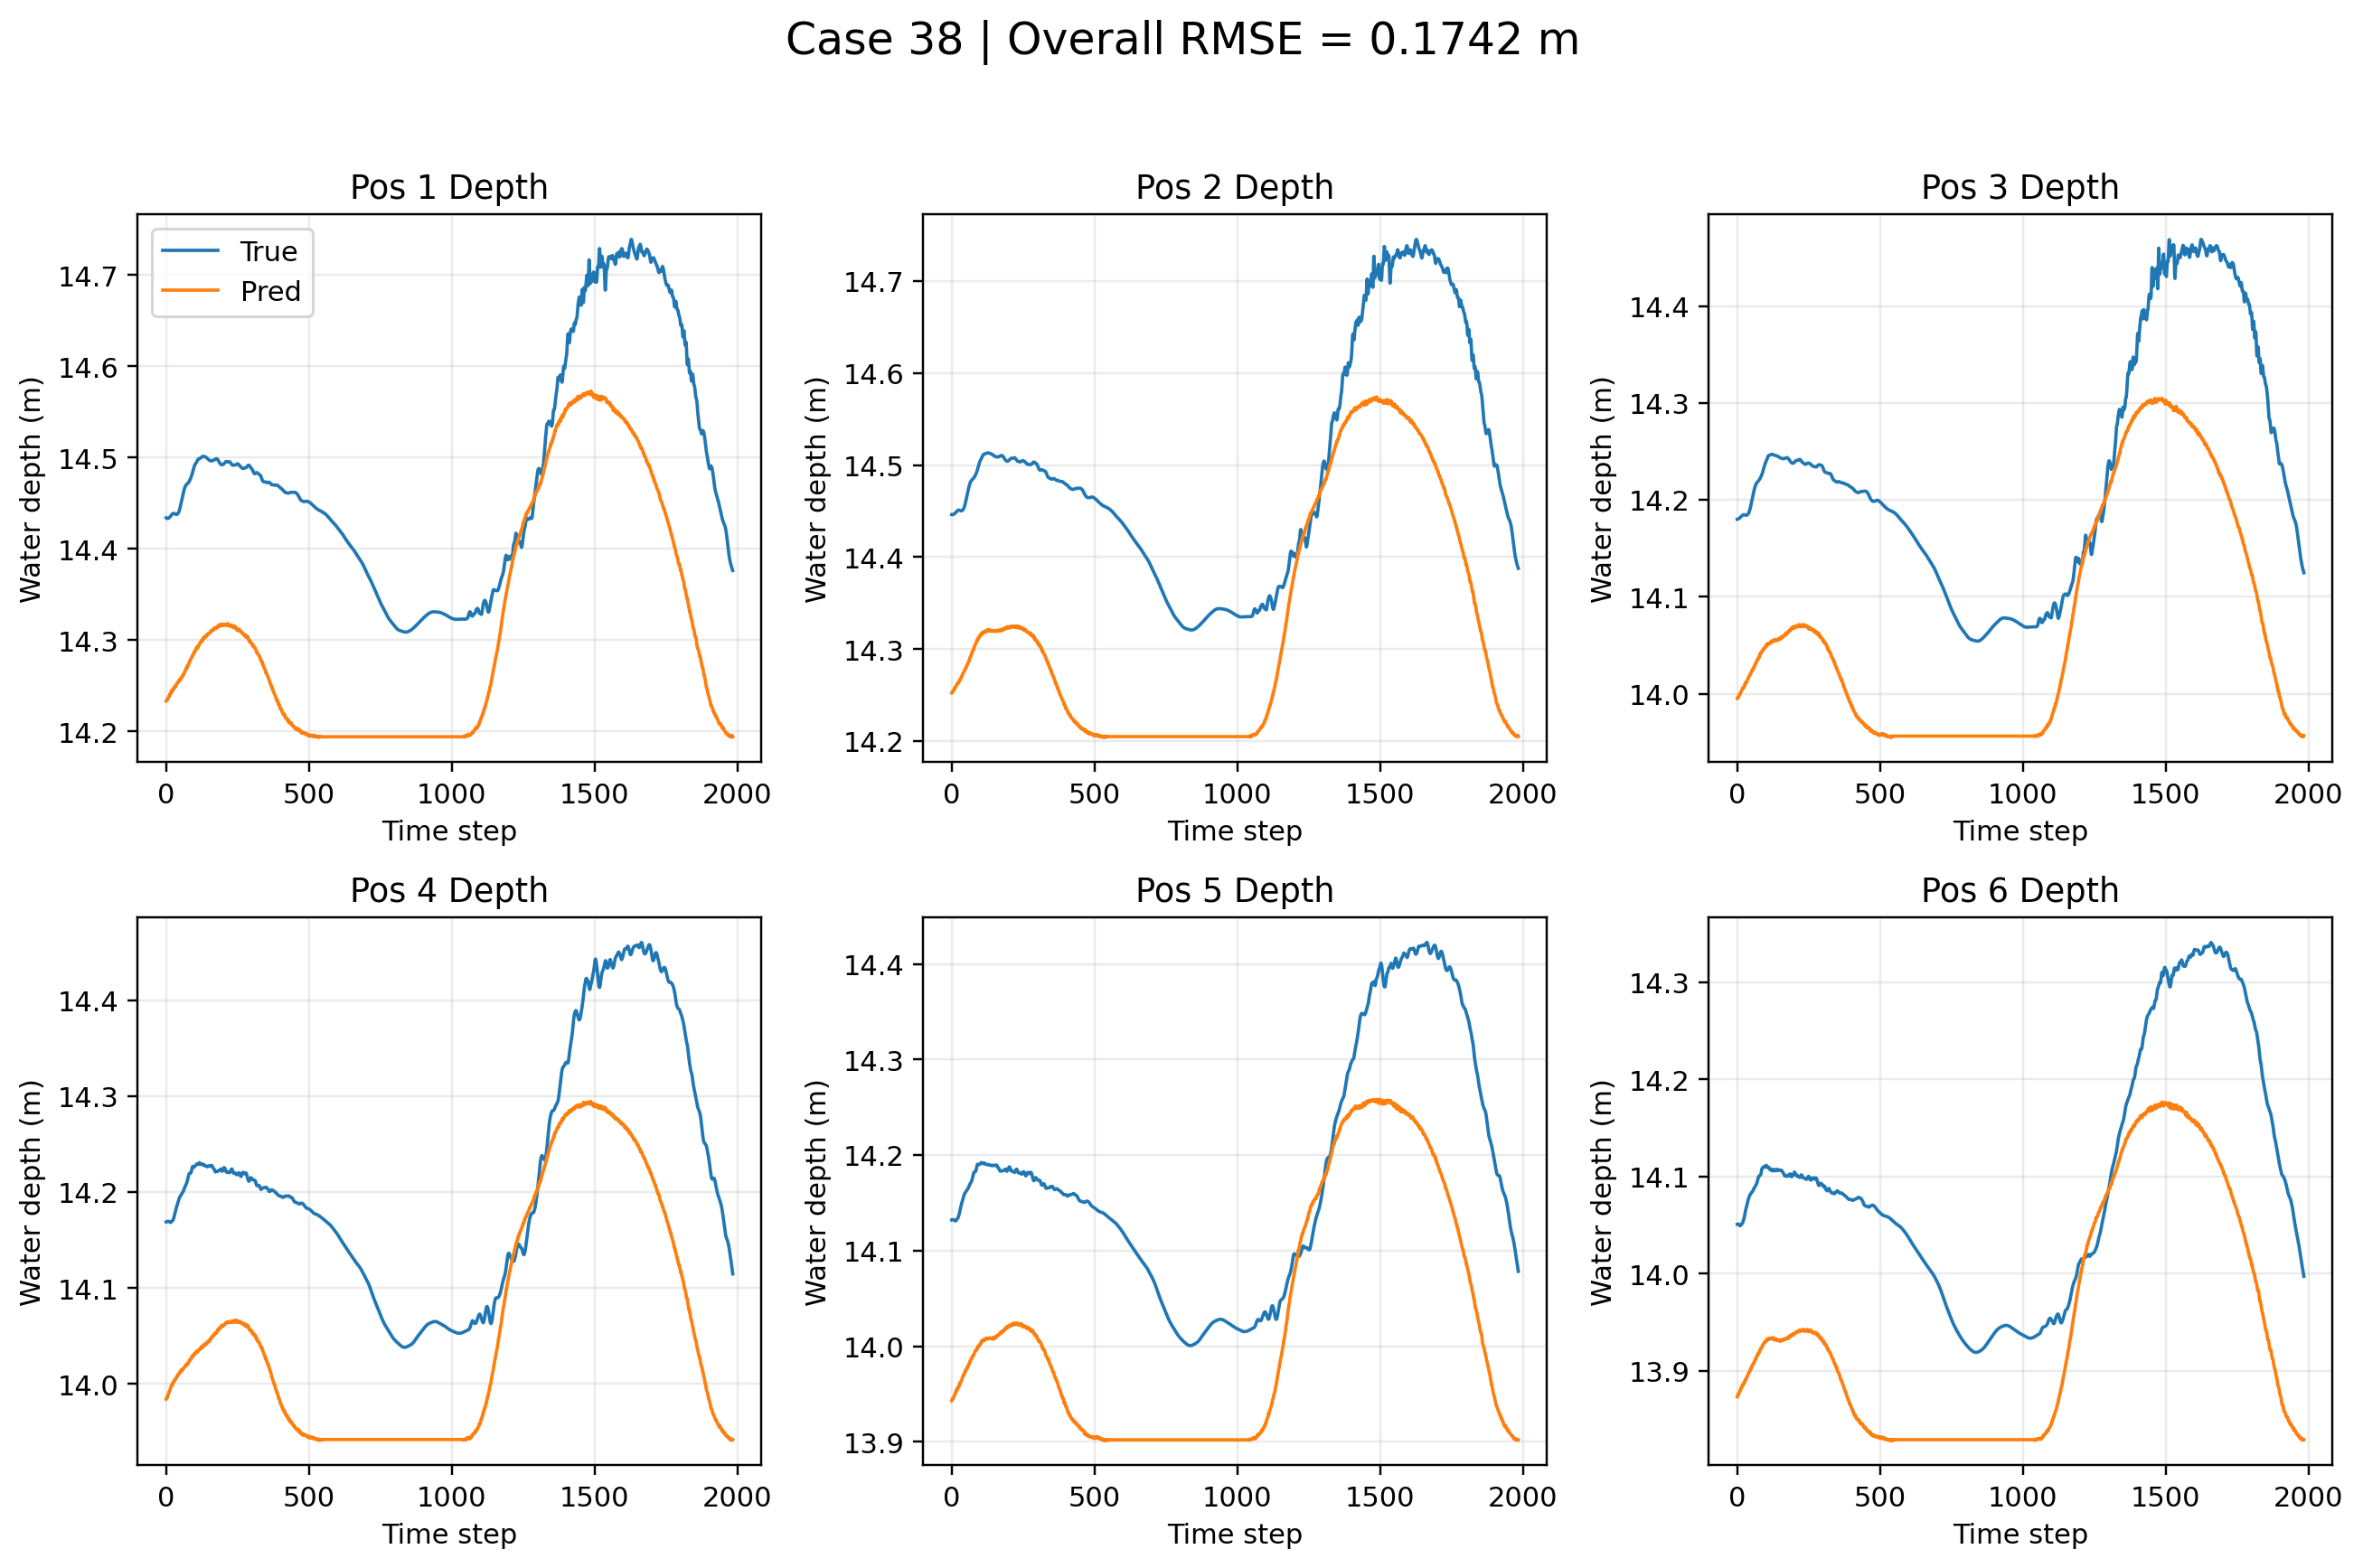

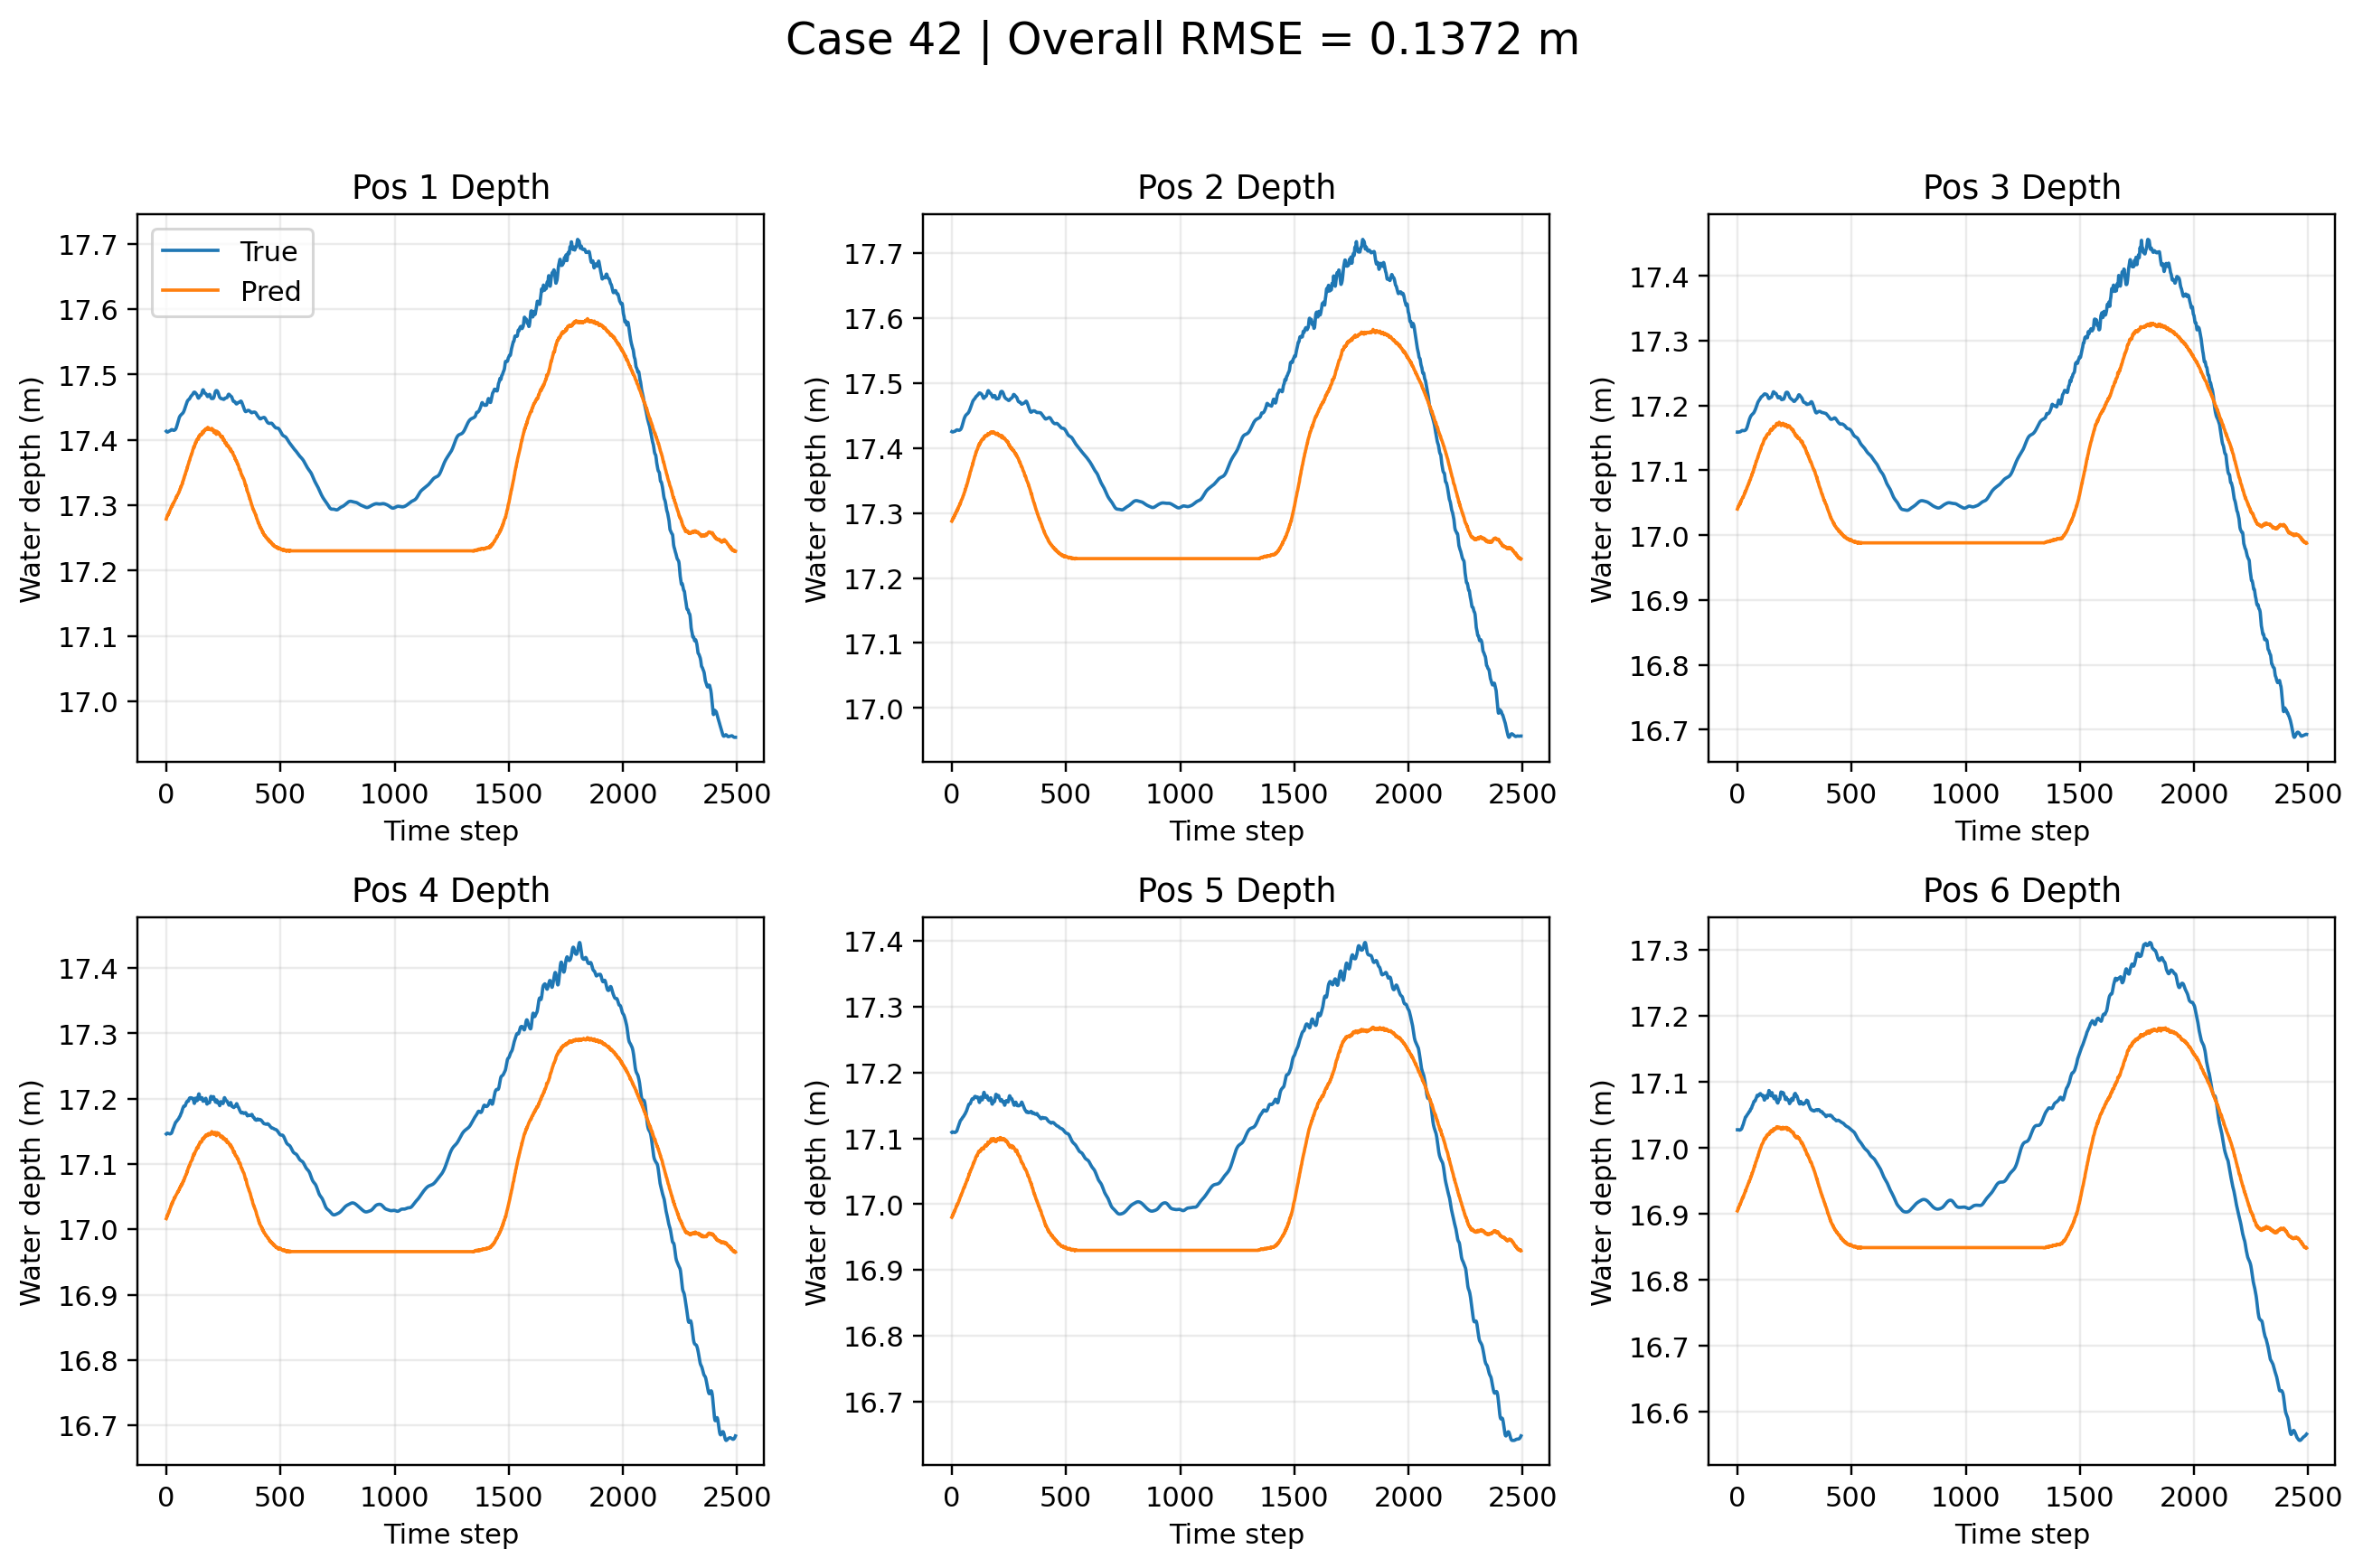

In [10]:
import matplotlib.pyplot as plt
import numpy as np

pos_names = [f"Pos {i}" for i in range(1, 7)]

for cid in sorted(test_data_per_case_norm.keys()):
    X_seq_case_norm, X_static_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_seq_case_norm, X_static_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)  
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)         
 
    rmse_case = float(np.sqrt(np.mean((y_pred_case_real - y_true_case_real) ** 2)))
 
    t = np.arange(y_true_case_real.shape[0])
 
    fig, axes = plt.subplots(
        2, 3,
        figsize=(12, 8),   
        dpi=220             
    )
    axes = axes.ravel()
 
    fig.suptitle(f"Case {cid} | Overall RMSE = {rmse_case:.4f} m", fontsize=16)

    for i in range(6):
        ax = axes[i]
        ax.plot(t, y_true_case_real[:, i], label="True", linewidth=1.2)
        ax.plot(t, y_pred_case_real[:, i], label="Pred", linewidth=1.2)

        ax.set_title(f"{pos_names[i]} Depth")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Water depth (m)")
        ax.grid(True, alpha=0.25)
 
        if i == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])   
    plt.show()
